# Проект: Отток клиентов

___
**Описание проекта**  

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
___
**Цель**  

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
___
**Описание данных:**  

Данные находятся в файле `/datasets/Churn.csv` (англ. «отток клиентов»).

*Признаки:*

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

*Целевой признак:*

- `Exited` — факт ухода клиента

## Подготовка данных

### Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`. Путь к файлу:

`/datasets/Churn.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats

In [2]:
#Инициализация модели дерева решений
from sklearn.tree import DecisionTreeClassifier

#Инициализация модели логистической регрессии
from sklearn.linear_model import LogisticRegression

#Инициализация модели CatBoost
from catboost import CatBoostClassifier

#Регрессия на основе k ближайших соседей
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

##Инициализация модели IsolationForest
from sklearn.ensemble import IsolationForest

#Проверка модели на адекватность
from sklearn.dummy import DummyClassifier

#Поиск лучших параметров модели
from sklearn.model_selection import GridSearchCV

#Преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

#Разделение выборки в заданных пропорциях
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, r2_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn.metrics import precision_recall_curve, accuracy_score

from sklearn.utils import shuffle

#Сохранение и загрузка обученной модели
import joblib

In [3]:
try:
    df = pd.read_csv('./Churn.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученном датафрейме

**Добавим настройки для удобства отображения данных**

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафрейма `df` на экран.**

In [5]:
df.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0    2.00       0.00              1          1               1   
1    1.00  83,807.86              1          0               1   
2    8.00 159,660.80              3          1               0   
3    1.00       0.00              2          0               0   
4    2.00 125,510.82              1          1               1   
5    8.00 113,755.78              2          1               0   
6    7.00       0.00              2          1               1   
7    4.00 115,046.74              4          1               0   
8    4.00 142,051.07              2          0               1   
9    2.00 134,603.88              1          1               1   

   EstimatedSalary  Exited  
0       101,348.88       1  
1       112,542.58       0  
2       113,931.57       1  
3        93,826.63       0  
4        79,084.10       0  
5       149,756.71       1  
6        10,062.80       0  
7       119,346.88       1  
8        74,940.50       0  
9        71,725.73       0

**Посмотрим на размер данных (количество строк, колонок).**

In [6]:
print(f'\nКоличество строк: {df.shape[0]}\nКоличество колонок: {df.shape[1]}\n')


Количество строк: 10000
Количество колонок: 14



**Для удобства, сразу приведем обозначения признаков к "змеиному" регистру.**

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df = df.rename(columns={
    'rownumber': 'row_number',
    'customerid': 'customer_id',
    'creditscore': 'credit_score',
    'numofproducts': 'num_of_products',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'estimatedsalary': 'estimated_salary'
})

In [9]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [10]:
df.describe(include = "all")

row_number   customer_id surname  credit_score geography gender  \
count    10,000.00     10,000.00   10000     10,000.00     10000  10000   
unique         NaN           NaN    2932           NaN         3      2   
top            NaN           NaN   Smith           NaN    France   Male   
freq           NaN           NaN      32           NaN      5014   5457   
mean      5,000.50 15,690,940.57     NaN        650.53       NaN    NaN   
std       2,886.90     71,936.19     NaN         96.65       NaN    NaN   
min           1.00 15,565,701.00     NaN        350.00       NaN    NaN   
25%       2,500.75 15,628,528.25     NaN        584.00       NaN    NaN   
50%       5,000.50 15,690,738.00     NaN        652.00       NaN    NaN   
75%       7,500.25 15,753,233.75     NaN        718.00       NaN    NaN   
max      10,000.00 15,815,690.00     NaN        850.00       NaN    NaN   

             age   tenure    balance  num_of_products  has_cr_card  \
count  10,000.00 9,091.00  10,000.00        10,000.00    10,000.00   
unique       NaN      NaN        NaN              NaN          NaN   
top          NaN      NaN        NaN              NaN          NaN   
freq         NaN      NaN        NaN              NaN          NaN   
mean       38.92     5.00  76,485.89             1.53         0.71   
std        10.49     2.89  62,397.41             0.58         0.46   
min        18.00     0.00       0.00             1.00         0.00   
25%        32.00     2.00       0.00             1.00         0.00   
50%        37.00     5.00  97,198.54             1.00         1.00   
75%        44.00     7.00 127,644.24             2.00         1.00   
max        92.00    10.00 250,898.09             4.00         1.00   

        is_active_member  estimated_salary    exited  
count          10,000.00         10,000.00 10,000.00  
unique               NaN               NaN       NaN  
top                  NaN               NaN       NaN  
freq                 NaN               NaN       NaN  
mean                0.52        100,090.24      0.20  
std                 0.50         57,510.49      0.40  
min                 0.00             11.58      0.00  
25%                 0.00         51,002.11      0.00  
50%                 1.00        100,193.91      0.00  
75%                 1.00        149,388.25      0.00  
max                 1.00        199,992.48      1.00

*Признаки:*

- `row_number` — индекс строки в данных
- `customer_id` — уникальный идентификатор клиента
- `surname` — фамилия
- `credit_score` — кредитный рейтинг
- `geography` — страна проживания
- `gender` — пол
- `age` — возраст
- `tenure` — сколько лет человек является клиентом банка
- `balance` — баланс на счёте
- `num_of_products` — количество продуктов банка, используемых клиентом
- `has_cr_card` — наличие кредитной карты
- `is_active_member` — активность клиента
- `estimated_salary` — предполагаемая зарплата

*Целевой признак:*

- `exited` — факт ухода клиента

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Выведем количество пропущенных значений для каждой колонки.**

In [12]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

**Выведем пропущенные значения в процентном соотношении.**

In [13]:
pd.DataFrame(df.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

**Проверим дубликаты.**

In [14]:
df.duplicated().sum()

0

**Посмотрим на распределения числовых признаков `credit_score`, `age`, `tenure`, `balance`, `estimated_salary`.**

In [15]:
def plots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for index in range(len(x)):
        
        plot = sns.histplot(data[x[index]],
                            color='blue',
                            stat='density',
                            ax=axes[0, index])
        sns.kdeplot(data[x[index]],
                    color='yellow',
                    alpha=0.5,
                    linewidth=3.5,
                    ax=axes[0, index])
        plot.axvline(data[x[index]].mean(), label='mean', c='k', ls='-', lw=2.5)
        plot.axvline(data[x[index]].median(), label='median', c='orange', ls='--', lw=2.5)
        axes[0, index].set(xlabel=xlabel)
        axes[0, index].set(ylabel=ylabel)
        
        sns.boxplot(data=data, x=x[index], color='yellow', ax=axes[1, index])
        sns.stripplot(data=data, x=x[index], color='blue', jitter=0.4, size=1.3, alpha=0.5, ax=axes[1, index])
        axes[1, index].set(xlabel=xlabel)
        axes[1, index].set(ylabel=ylabel)
        
        sns.violinplot(data=data, x=x[index],color='yellow', ax=axes[2, index])
        axes[2, index].set(xlabel=xlabel)
        axes[2, index].set(ylabel=ylabel)

        axes[0, index].set_title(title[x[index]], fontsize=18, pad=15)
    
    fig.suptitle(suptitle, fontsize=22)
    plt.show()

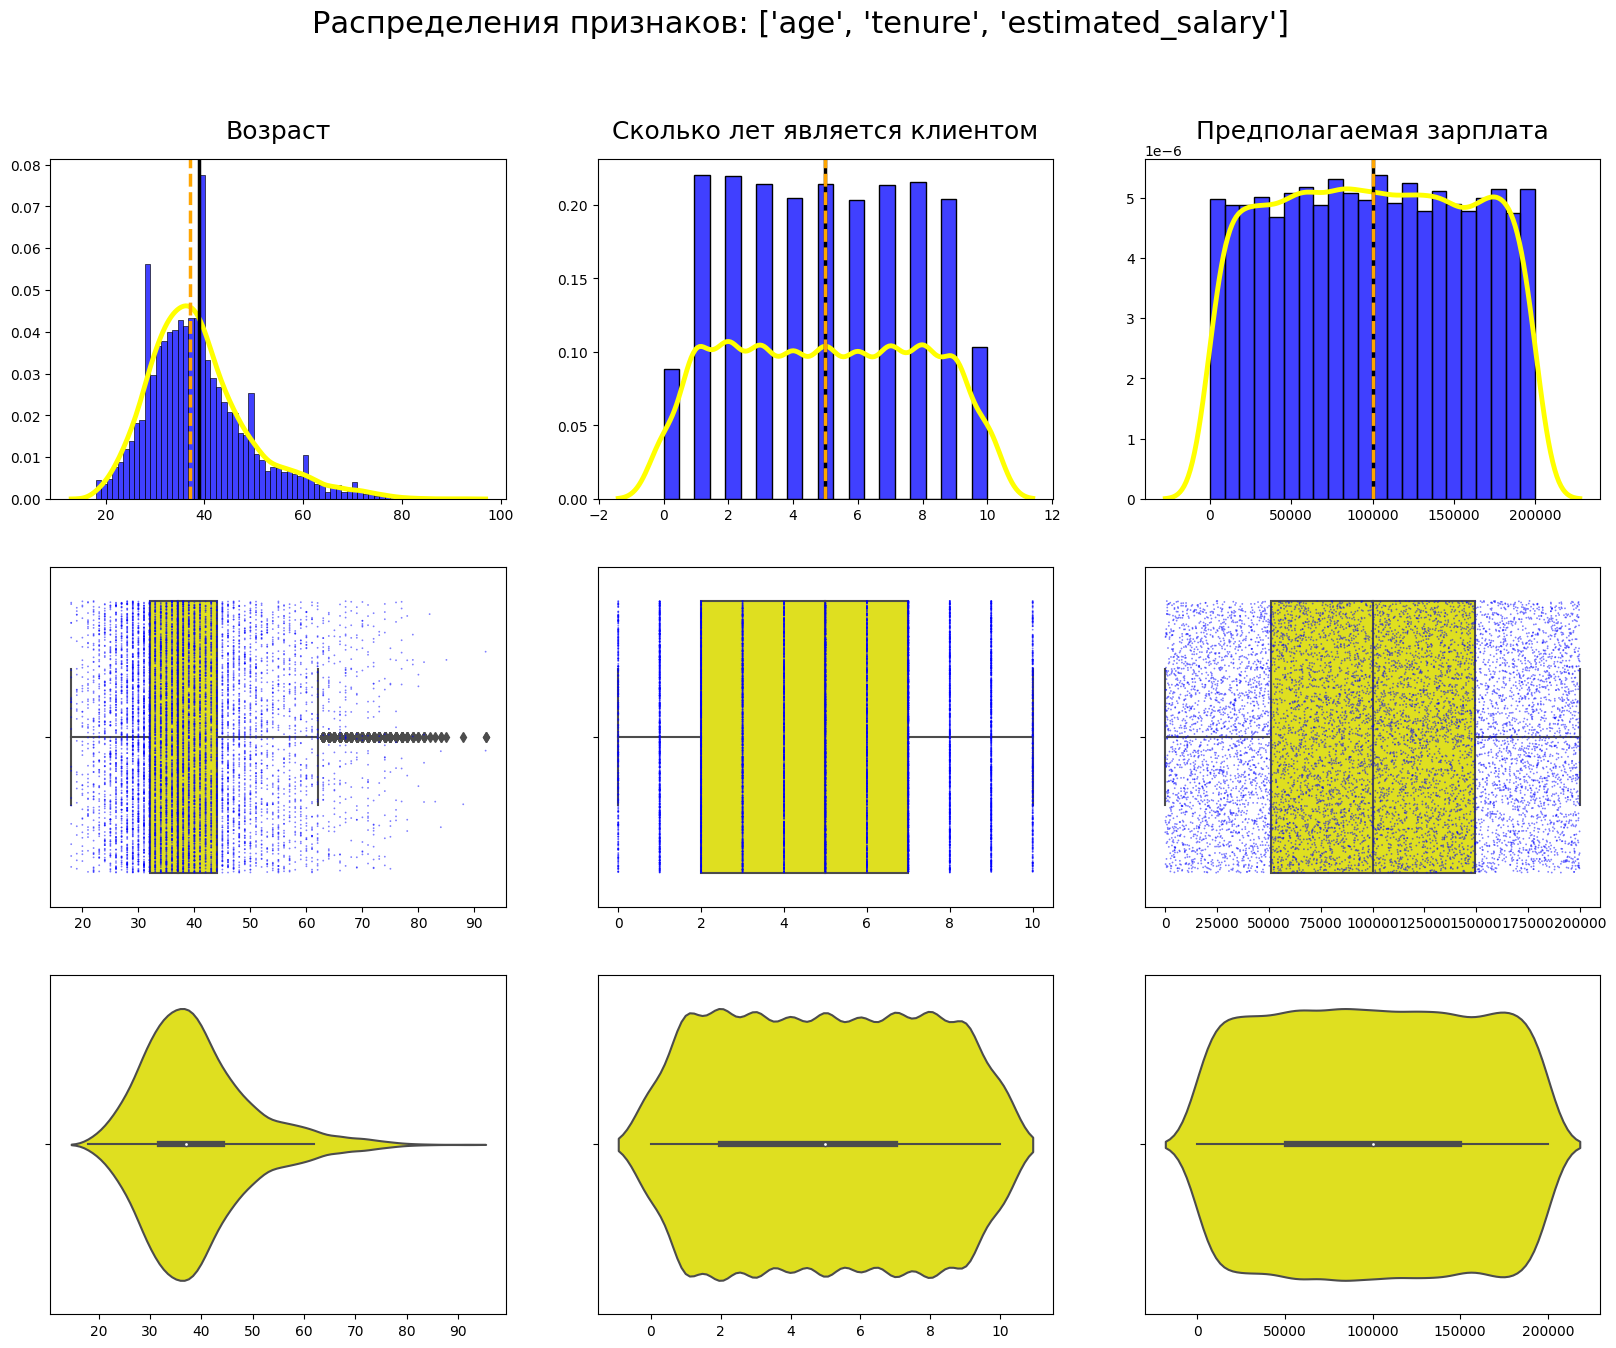

In [16]:
numerical = ['age', 'tenure', 'estimated_salary']

plots_numerics(data=df,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'age': 'Возраст',
                      'tenure': 'Сколько лет является клиентом',
                      'estimated_salary': 'Предполагаемая зарплата'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=3,
               figsize=(20, 15))

**В признаке `age` заметны выбросы, медиана и средняя смещены вправо к выбросам. В признаках `tenure`, `estimated_salary` аномалий не замечено.**

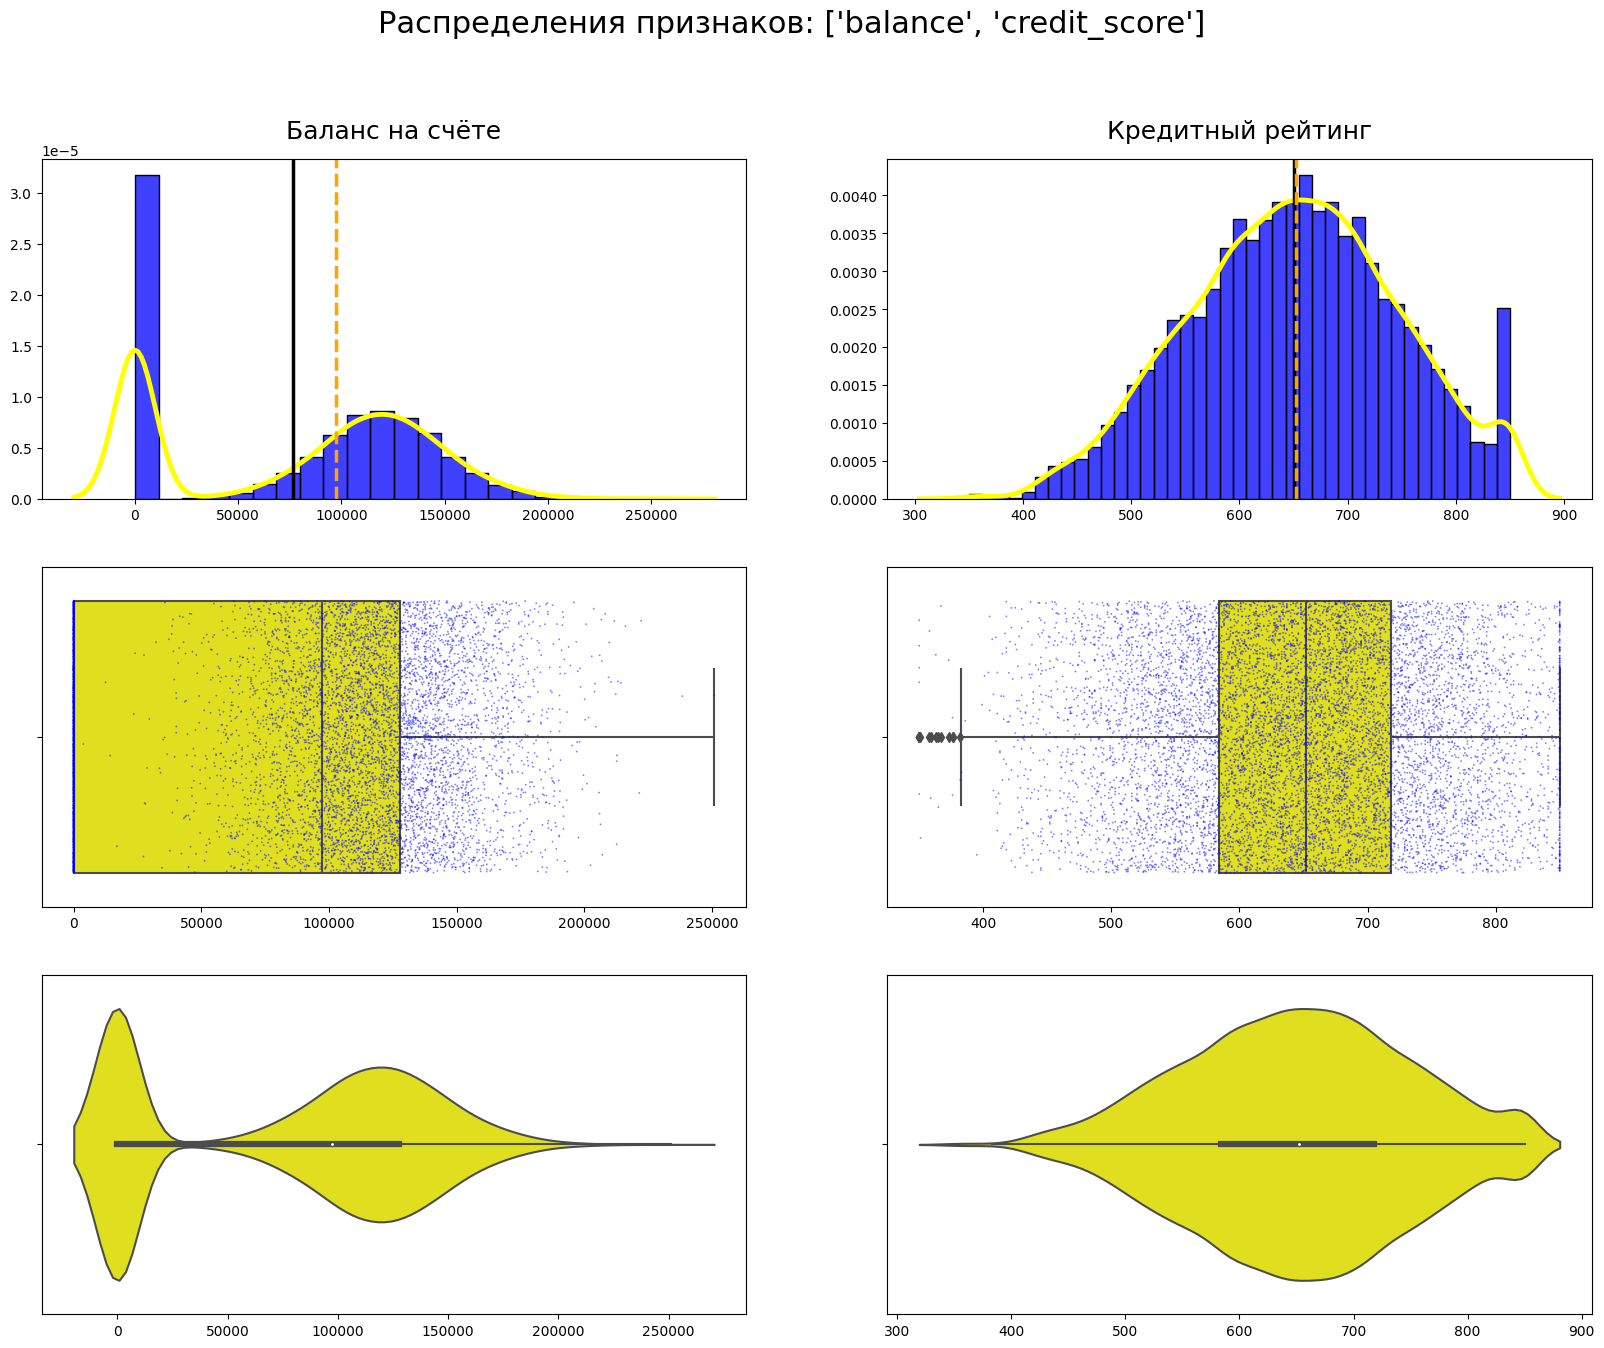

In [17]:
numerical = ['balance', 'credit_score']

plots_numerics(data=df,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'balance': 'Баланс на счёте',
                      'credit_score': 'Кредитный рейтинг'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(20, 15))

**В признаке `credit_score` на графике `boxplot`заметны выбросы. Признак `balance` распределен нормально, если не учитывать клиентов с нулевым балансом, которые сильно перетягивают на себя среднюю и медиану.**

**Посмотрим на распределение целевого признака `exited`.**

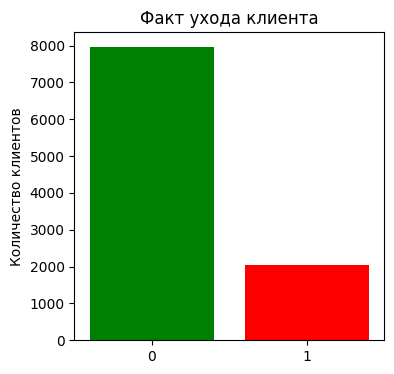

In [18]:
plt.figure(figsize=(4, 4))
palette = {0: 'green', 1: 'red'}
sns.countplot(data=df, x='exited', palette=palette, saturation=1)
plt.xlabel(None)
plt.ylabel('Количество клиентов')
plt.title('Факт ухода клиента')
plt.show()

**Явный дисбаланс классов в признаке `exited`, несбалансирован примерно 4:1.**

**Посмотрим на распределения категориальных признаков `geography`, `gender`, `has_cr_card`, `is_active_member`, `num_of_products`.**

In [19]:
def countplot_categories(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, hue=None, figsize=(3 , 3)):
    
    plt.figure(figsize=figsize)
    
    for i in enumerate(x):
        palette = {0: 'green', 1: 'red'}
        plt.subplot(nrows, ncols, i[0] + 1)
        sns.countplot(data=data, x=i[1], hue=hue, dodge=False, saturation=1, palette=palette)
        plt.xlabel(i[1])
        plt.ylabel(ylabel)
        plt.title(title[i[1]], fontsize=18, pad=5)

    plt.suptitle(suptitle, fontsize=22)
    plt.show()

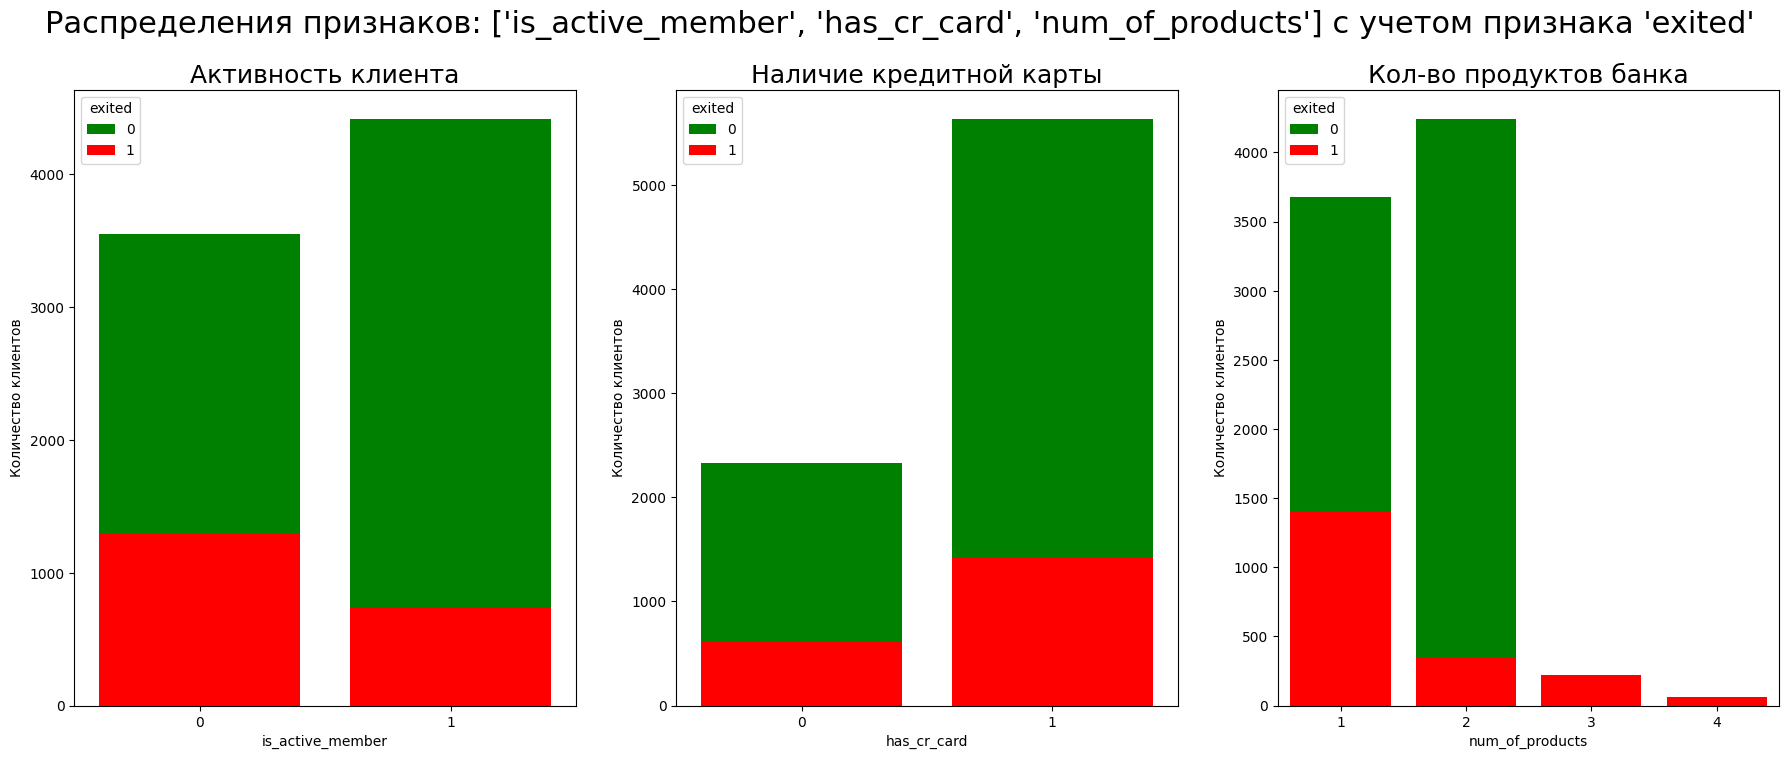

In [20]:
categories = ['is_active_member', 'has_cr_card', 'num_of_products']

hue='exited'

countplot_categories(data=df,
                     x=categories,
                     xlabel=None,
                     ylabel='Количество клиентов',
                     hue=hue,
                     title={'is_active_member': 'Активность клиента',
                            'has_cr_card': 'Наличие кредитной карты',
                            'num_of_products': 'Кол-во продуктов банка'},
                     suptitle=(f'Распределения признаков: {categories} c учетом признака \'{hue}\''),
                     nrows=1,
                     ncols=3,
                     figsize=(22, 8))

**Дисбаланс классов в признаках `has_cr_card`, `num_of_products`. Интересный факт, те, у кого `3` или `4` продукта в `100%` перестали пользоваться продуктом. Классы в признаке `is_active_member` выглядят относительно сбалансированно.**

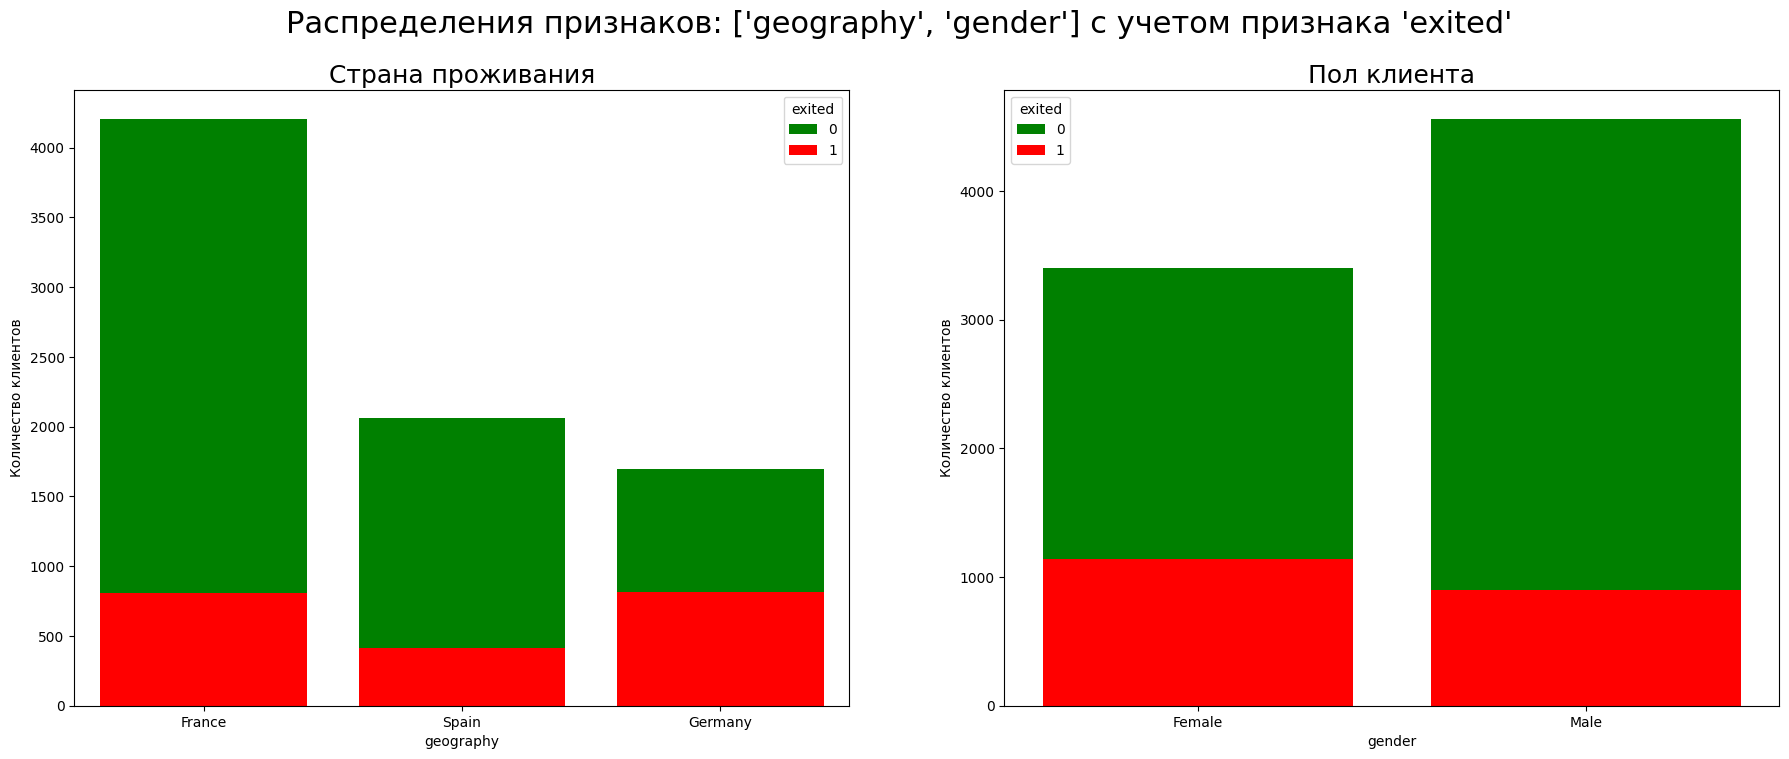

In [21]:
categories = ['geography', 'gender']

hue='exited'

countplot_categories(data=df,
                     x=categories,
                     xlabel=None,
                     ylabel='Количество клиентов',
                     hue=hue,
                     title={'geography': 'Страна проживания',
                            'gender': 'Пол клиента'},
                     suptitle=(f'Распределения признаков: {categories} c учетом признака \'{hue}\''),
                     nrows=1,
                     ncols=2,
                     figsize=(22, 8))

**Дисбаланс классов в признаке `geography`, клиентов с `Франции` примерно в два раза больше по сравнению с остальными. Классы в признаке `gender` выглядят относительно сбалансированно.**

**Матрица корреляций:**

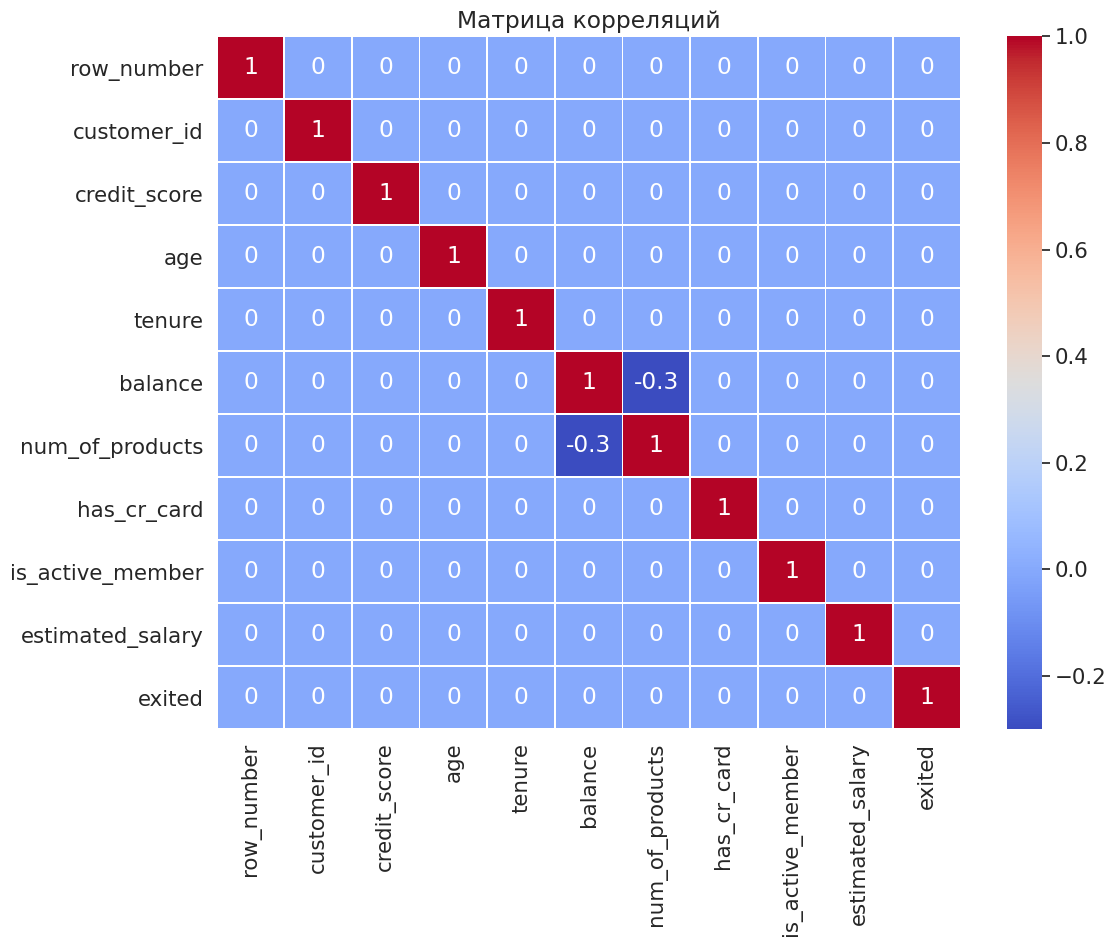

In [22]:
plt.figure(figsize=(12, 9))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

**Выраженных `линейных корреляций` между признаками `не выявлено`.**

**Выявлены следующие проблемы:**

>1. Привести обозначения признаков к `"змеиному" регистру`;
>2. Избавится от лишних признаков `row_number`, `customer_id`, `surname`;
>3. В признаках `age`, `credit_score`, следует избавится от выбросов;
>4. В признаке `tenure` следует избавится от пропусков;
>5. Для `линейных моделей` необходимо преобразовать масштаб количественных признаков `credit_score`, `age`, `tenure`, `balance`, `estimated_salary` методом стандартизации.
>6. Дисбаланс категориальных признаков `exited`, `has_cr_card` и `geography`.

**Рассмотрим выбросы в признаке `age`.**

In [23]:
def feature_plots(data, x, y, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    sns.scatterplot(data=data, x=x, y=y, color='blue', ax=axes[0])
    axes[0].set(xlabel=None)
    axes[0].set(ylabel=None)
    
    plot = sns.histplot(data=data,
                        x=x,
                        color='blue',
                        stat='density',
                        ax=axes[1])
    plot.axvline(data[x].mean(), label='mean', c='k', ls='-', lw=2.5)
    plot.axvline(data[x].median(), label='median', c='orange', ls='--', lw=2.5)
    sns.kdeplot(data=data,
                x=x,
                color='yellow',
                alpha=0.5,
                linewidth=3.5,
                ax=axes[1])
    axes[1].set(xlabel=None)
    axes[1].set(ylabel=None)
    
    fig.suptitle(suptitle, fontsize=22)
    plt.legend()
    plt.show()

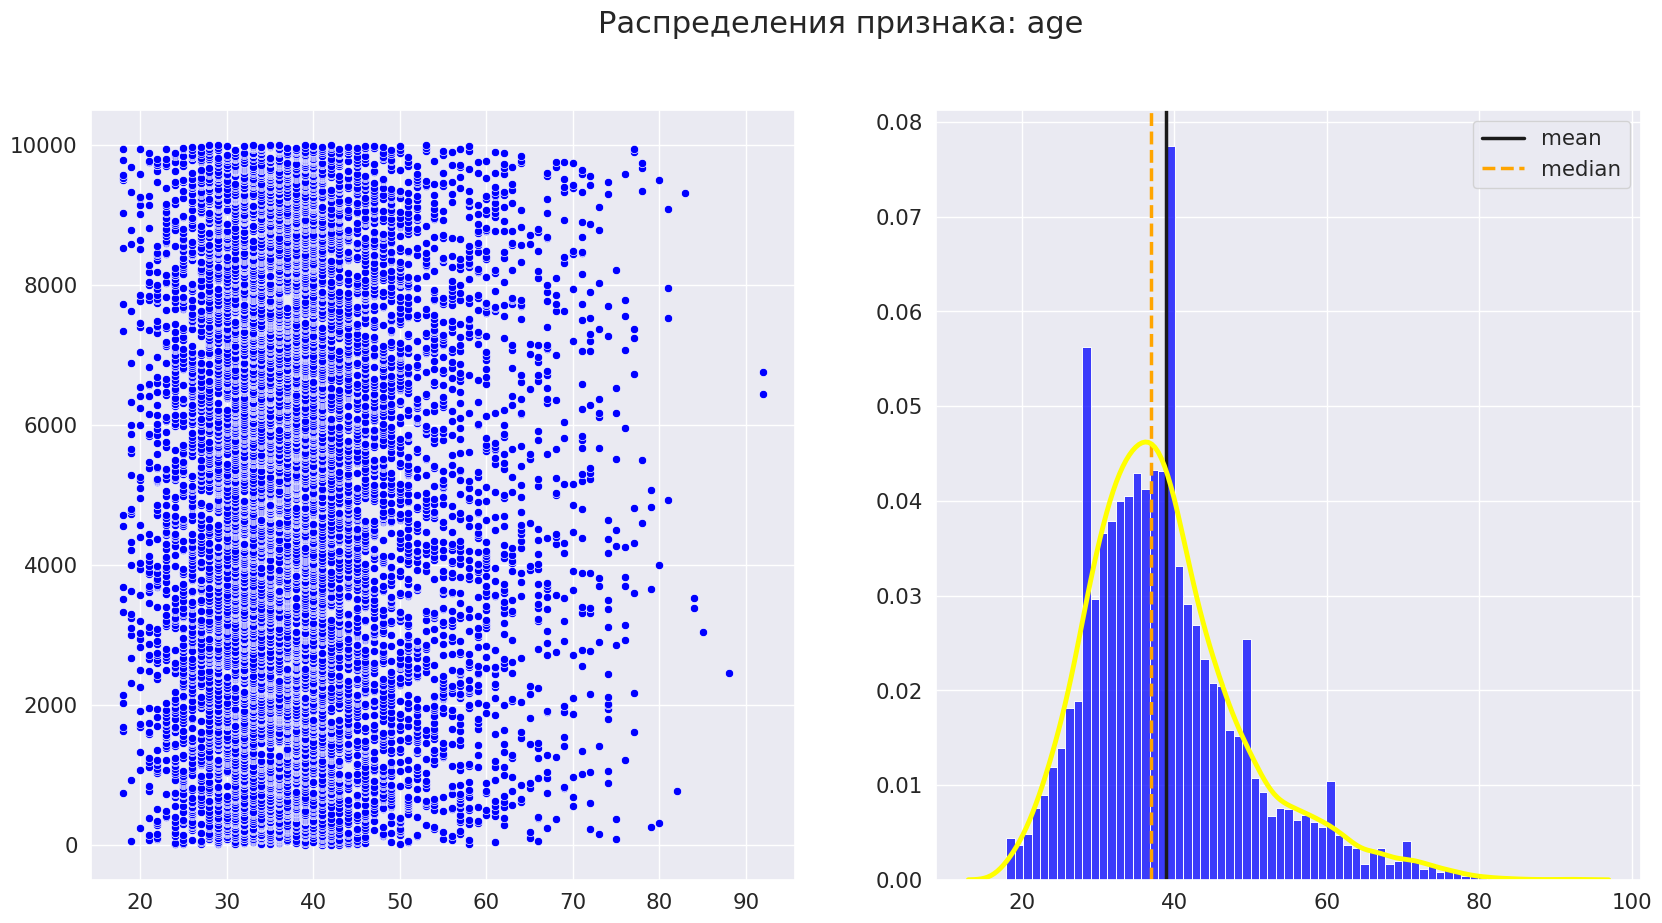

In [24]:
x = 'age'
y = 'row_number'

feature_plots(data=df,
              x=x,
              y=y,
              xlabel=None,
              ylabel=None,
              suptitle=(f'Распределения признака: {x}'),
              nrows=1,
              ncols=2,
              figsize=(20, 10))

**Посчитаем процент выбросов в признаке `age` методом "z оценки".**

In [25]:
z = np.abs(stats.zscore(df['age']))

In [26]:
outliners = df['age'].iloc[np.where(z > 3)].count() / df['age'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 1.33%


**Найдем выбросы в признаке `age` обучив модель `IsolationForest`. Полученные данные сохраним в признаке `outliers`.**

In [27]:
clf = IsolationForest(max_samples=100, contamination=0.0133, random_state=42, n_jobs=-1)
df['outliers'] = clf.fit_predict(df[['age']])

df.head()

row_number  customer_id   surname  credit_score geography  gender  age  \
0           1     15634602  Hargrave           619    France  Female   42   
1           2     15647311      Hill           608     Spain  Female   41   
2           3     15619304      Onio           502    France  Female   42   
3           4     15701354      Boni           699    France  Female   39   
4           5     15737888  Mitchell           850     Spain  Female   43   

   tenure    balance  num_of_products  has_cr_card  is_active_member  \
0    2.00       0.00                1            1                 1   
1    1.00  83,807.86                1            0                 1   
2    8.00 159,660.80                3            1                 0   
3    1.00       0.00                2            0                 0   
4    2.00 125,510.82                1            1                 1   

   estimated_salary  exited  outliers  
0        101,348.88       1         1  
1        112,542.58       0         1  
2        113,931.57       1         1  
3         93,826.63       0         1  
4         79,084.10       0         1

**Количество найденных строк с выбросами данных:**

In [28]:
df.loc[df['outliers'] == -1, 'outliers'].count()

133

**Отобразим найденные выбросы графически.**

In [29]:
def feature_outliers_plots(data, x, y, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    markers = {1: 'o', -1: 'X'}
    palette = {1: 'blue', -1: 'red'}
    sns.scatterplot(data=data, x=x, y=y, hue='outliers', style='outliers', markers=markers, palette=palette, ax=axes[0])
    axes[0].set(xlabel=None)
    axes[0].set(ylabel=None)
    
    plot = sns.histplot(data=data,
                        x=x,
                        stat='density',
                        hue='outliers',
                        palette=palette,
                        kde=True,
                        ax=axes[1])
    plot.axvline(data[x].mean(), label='mean', c='k', ls='-', lw=2.5)
    plot.axvline(data[x].median(), label='median', c='orange', ls='--', lw=2.5)

    axes[1].set(xlabel=None)
    axes[1].set(ylabel=None)
    
    fig.suptitle(suptitle, fontsize=22)
    plt.show()

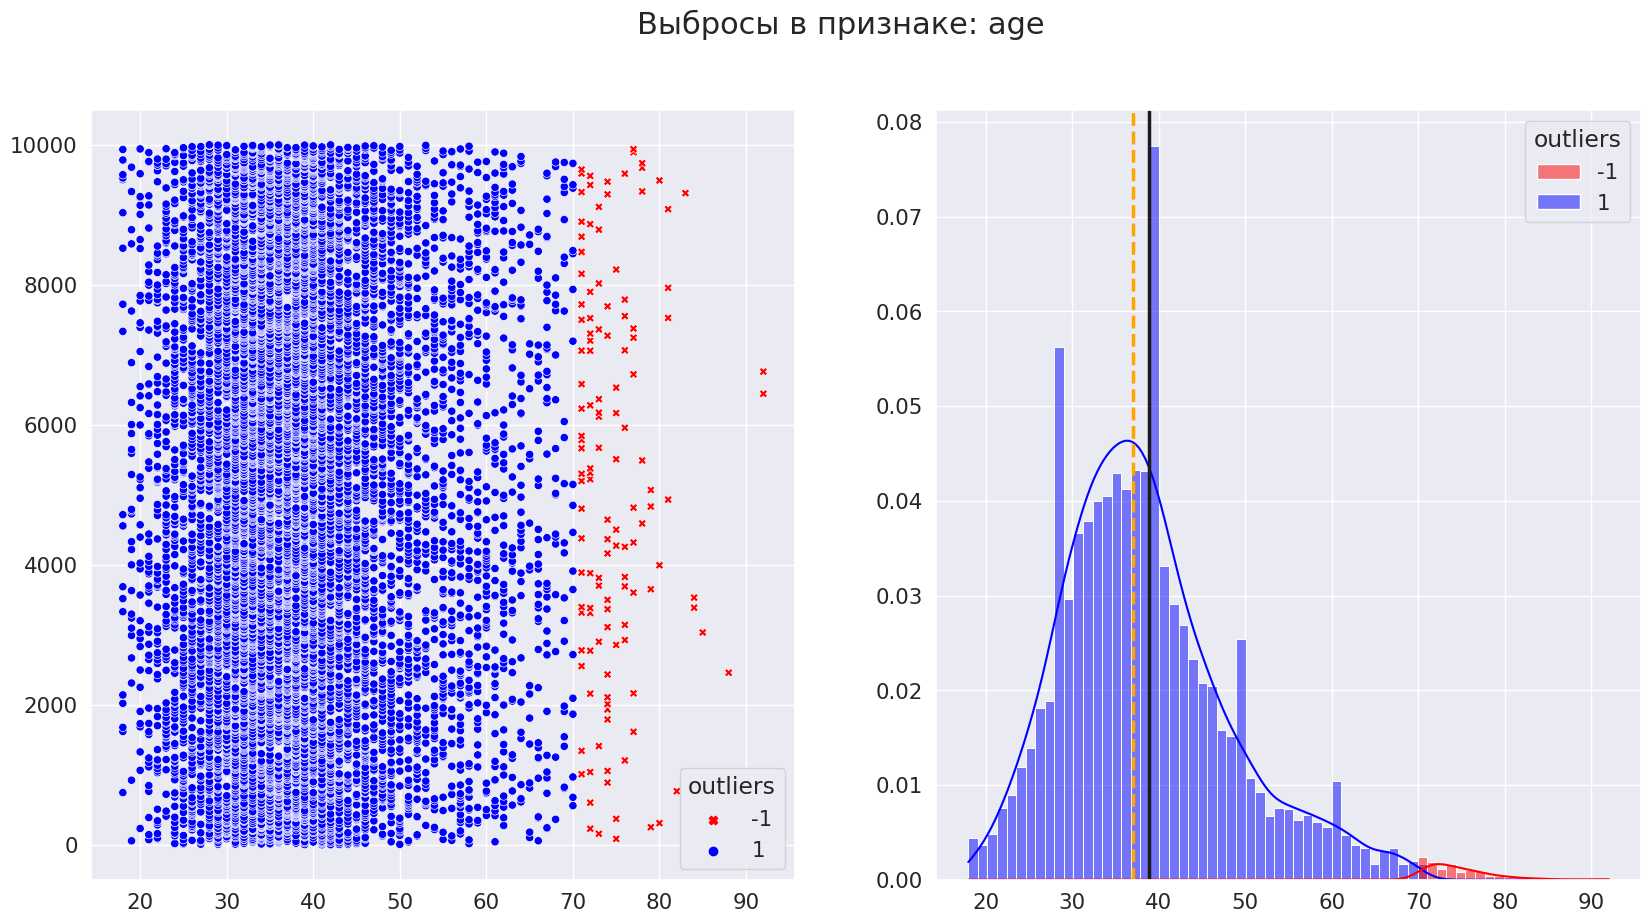

In [30]:
x = 'age'
y = 'row_number'

feature_outliers_plots(data=df,
                       x=x,
                       y=y,
                       xlabel=None,
                       ylabel=None,
                       suptitle=(f'Выбросы в признаке: {x}'),
                       nrows=1,
                       ncols=2,
                       figsize=(20, 10))

**Удалим выбросы в признаке `age`.**

In [31]:
df = df.loc[df['outliers'] == 1]

**Рассмотрим выбросы в признаке `credit_score`.**

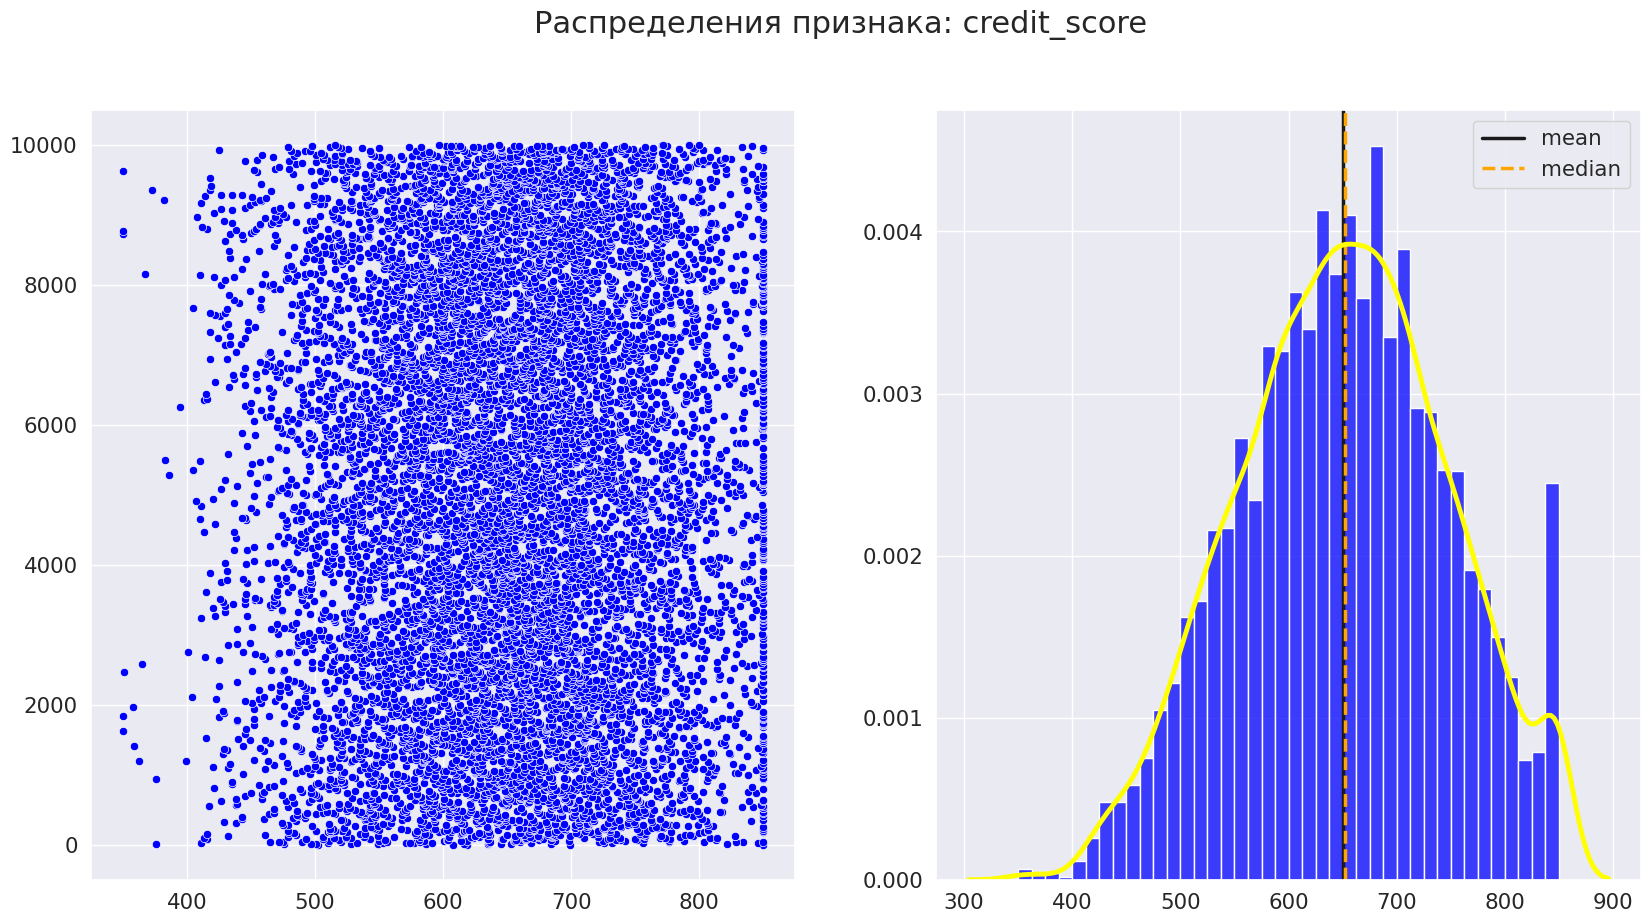

In [32]:
x = 'credit_score'
y = 'row_number'

feature_plots(data=df,
              x=x,
              y=y,
              xlabel=None,
              ylabel=None,
              suptitle=(f'Распределения признака: {x}'),
              nrows=1,
              ncols=2,
              figsize=(20, 10))

**Посчитаем процент выбросов в признаке `credit_score` методом "z оценки".**

In [33]:
z = np.abs(stats.zscore(df['credit_score']))

In [34]:
outliners = df['credit_score'].iloc[np.where(z > 3)].count() / df['credit_score'].shape[0]
print(f'Процент выбросов равен: {outliners:.2%}')

Процент выбросов равен: 0.08%


**Найдем выбросы в признаке `credit_score` обучив модель `IsolationForest`. Полученные данные сохраним в признаке `outliers`.**

In [35]:
clf = IsolationForest(max_samples=100, contamination=0.0008, random_state=42, n_jobs=-1)
df['outliers'] = clf.fit_predict(df[['credit_score']])

df.head()

row_number  customer_id   surname  credit_score geography  gender  age  \
0           1     15634602  Hargrave           619    France  Female   42   
1           2     15647311      Hill           608     Spain  Female   41   
2           3     15619304      Onio           502    France  Female   42   
3           4     15701354      Boni           699    France  Female   39   
4           5     15737888  Mitchell           850     Spain  Female   43   

   tenure    balance  num_of_products  has_cr_card  is_active_member  \
0    2.00       0.00                1            1                 1   
1    1.00  83,807.86                1            0                 1   
2    8.00 159,660.80                3            1                 0   
3    1.00       0.00                2            0                 0   
4    2.00 125,510.82                1            1                 1   

   estimated_salary  exited  outliers  
0        101,348.88       1         1  
1        112,542.58       0         1  
2        113,931.57       1         1  
3         93,826.63       0         1  
4         79,084.10       0         1

**Количество найденных строк с выбросами данных:**

In [36]:
df[df['outliers'] == -1]['credit_score'].count()

6

**Отобразим найденные выбросы графически.**

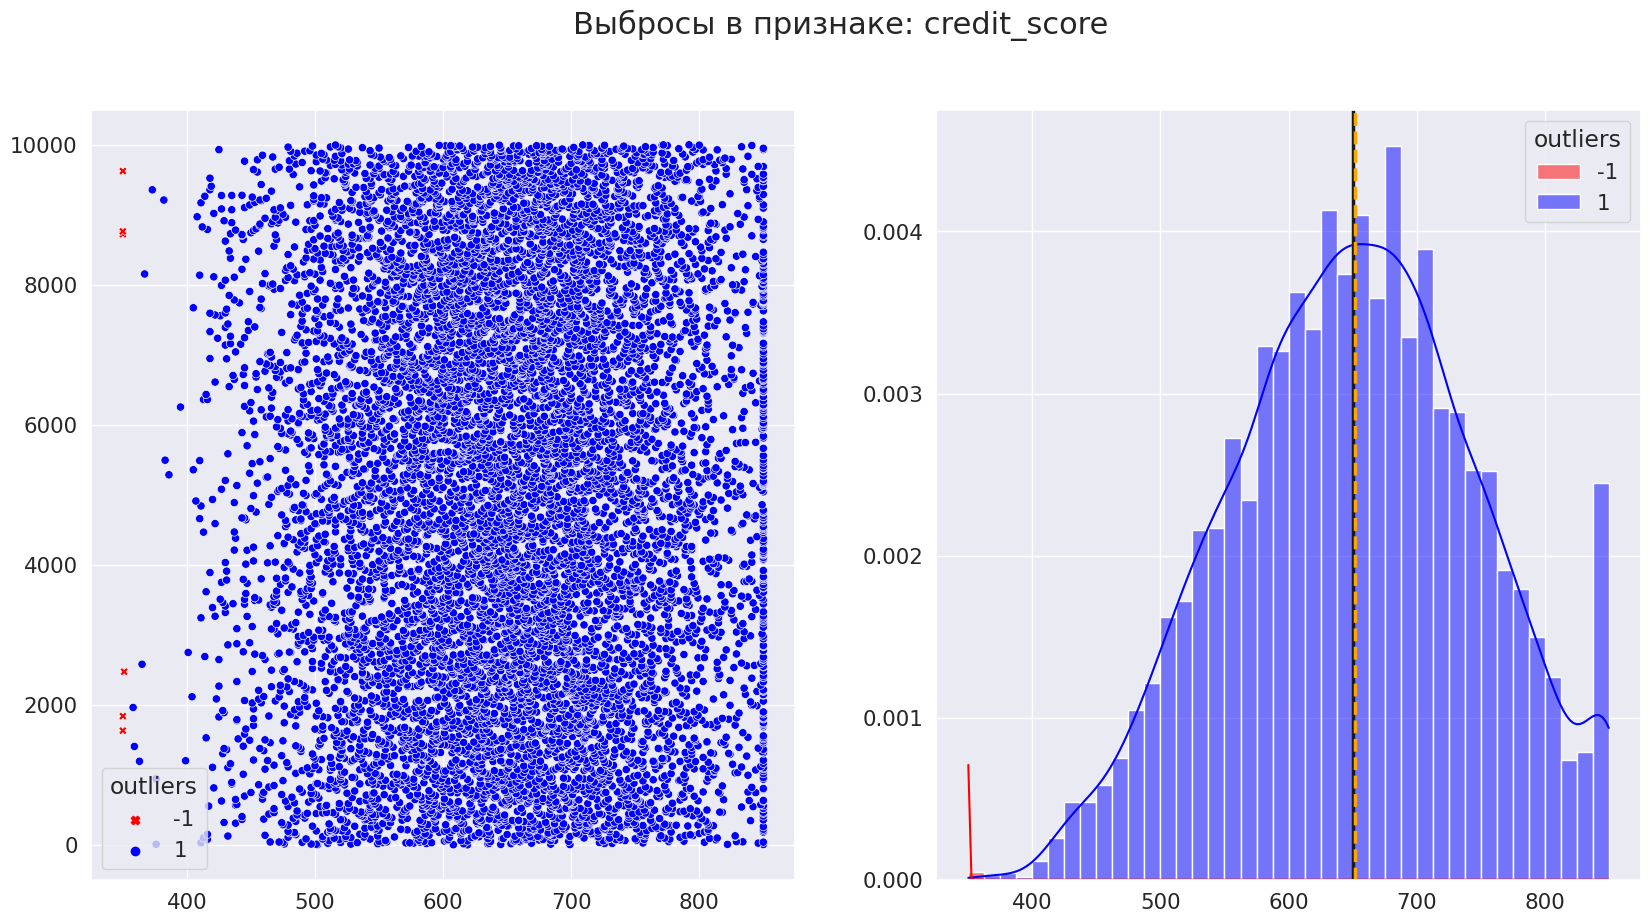

In [37]:
x = 'credit_score'
y = 'row_number'

feature_outliers_plots(data=df,
                       x=x,
                       y=y,
                       xlabel=None,
                       ylabel=None,
                       suptitle=(f'Выбросы в признаке: {x}'),
                       nrows=1,
                       ncols=2,
                       figsize=(20, 10))

**Удалим выбросы в признаке `credit_score`.**

In [38]:
df = df.loc[df['outliers'] == 1]

**Рассмотрим выбросы в признаке `balance`.**

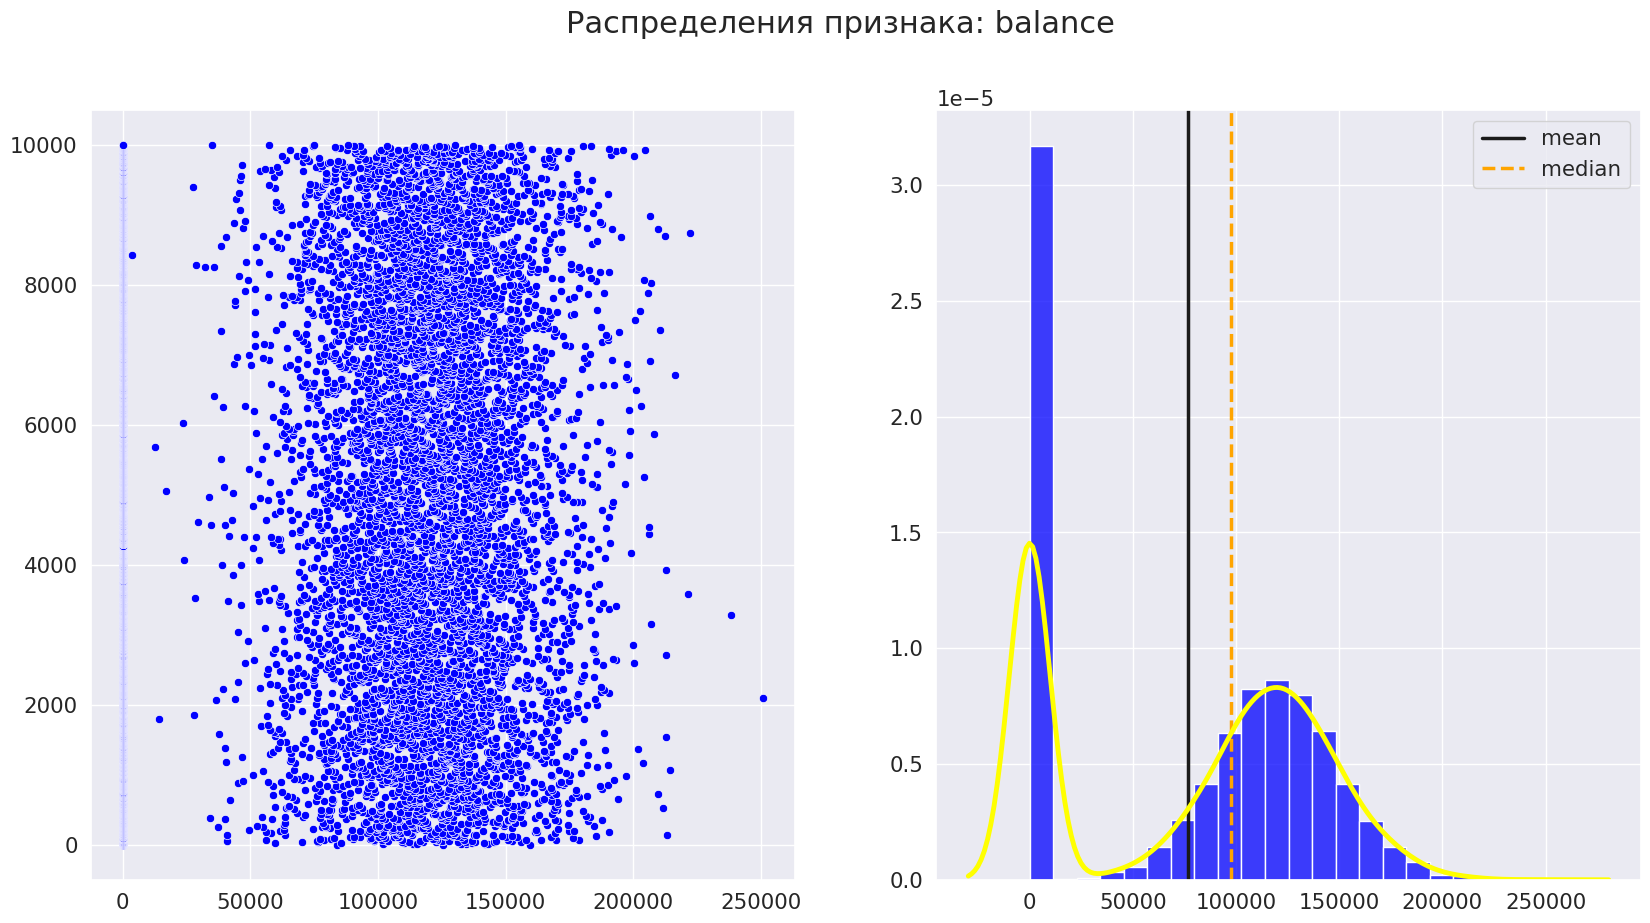

In [39]:
x = 'balance'
y = 'row_number'

feature_plots(data=df,
              x=x,
              y=y,
              xlabel=None,
              ylabel=None,
              suptitle=(f'Распределения признака: {x}'),
              nrows=1,
              ncols=2,
              figsize=(20, 10))

**Посчитаем процент выбросов в признаке `balance` методом "z оценки".**

In [40]:
z = np.abs(stats.zscore(df['balance']))

In [41]:
outliners = df['balance'].iloc[np.where(z > 3)].count() / df['balance'].shape[0]
print(f'Процент выбросов равен: {outliners:.5%}')

Процент выбросов равен: 0.00000%


**Найдем выбросы в признаке `balance` обучив модель `IsolationForest`. Полученные данные сохраним в признаке `outliers`.**

In [42]:
clf = IsolationForest(max_samples=100, contamination=0.003, random_state=42, n_jobs=-1)
df['outliers'] = clf.fit_predict(df[['balance']])

df.head()

row_number  customer_id   surname  credit_score geography  gender  age  \
0           1     15634602  Hargrave           619    France  Female   42   
1           2     15647311      Hill           608     Spain  Female   41   
2           3     15619304      Onio           502    France  Female   42   
3           4     15701354      Boni           699    France  Female   39   
4           5     15737888  Mitchell           850     Spain  Female   43   

   tenure    balance  num_of_products  has_cr_card  is_active_member  \
0    2.00       0.00                1            1                 1   
1    1.00  83,807.86                1            0                 1   
2    8.00 159,660.80                3            1                 0   
3    1.00       0.00                2            0                 0   
4    2.00 125,510.82                1            1                 1   

   estimated_salary  exited  outliers  
0        101,348.88       1         1  
1        112,542.58       0         1  
2        113,931.57       1         1  
3         93,826.63       0         1  
4         79,084.10       0         1

**Количество найденных строк с выбросами данных:**

In [43]:
df[df['outliers'] == -1]['credit_score'].count()

27

**Отобразим найденные выбросы графически.**

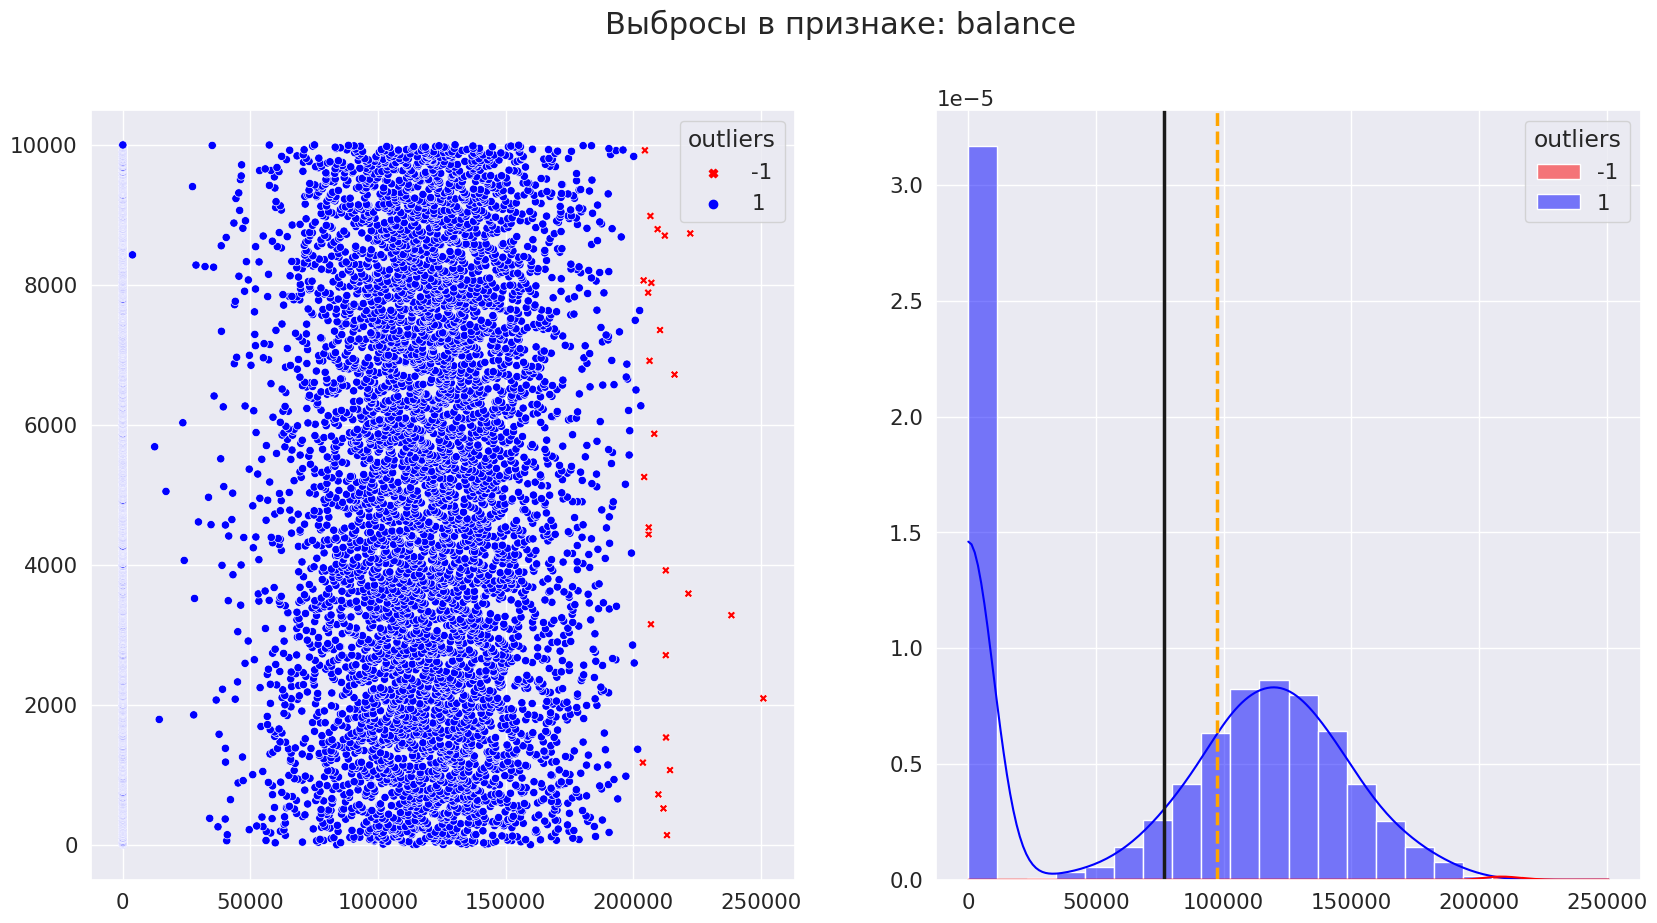

In [44]:
x = 'balance'
y = 'row_number'

feature_outliers_plots(data=df,
                       x=x,
                       y=y,
                       xlabel=None,
                       ylabel=None,
                       suptitle=(f'Выбросы в признаке: {x}'),
                       nrows=1,
                       ncols=2,
                       figsize=(20, 10))

**Методом `z оценки` выбросы не обнаружены. Модель `IsolationForest` клиентов с нулевым балансом тоже не сочла выбросами.**

**Удалим признак `outliers`.**

In [45]:
df = df.drop(columns=['outliers'])

**Посмотрим как изменились распределения данных в признаках `age` и `credit_score`.**

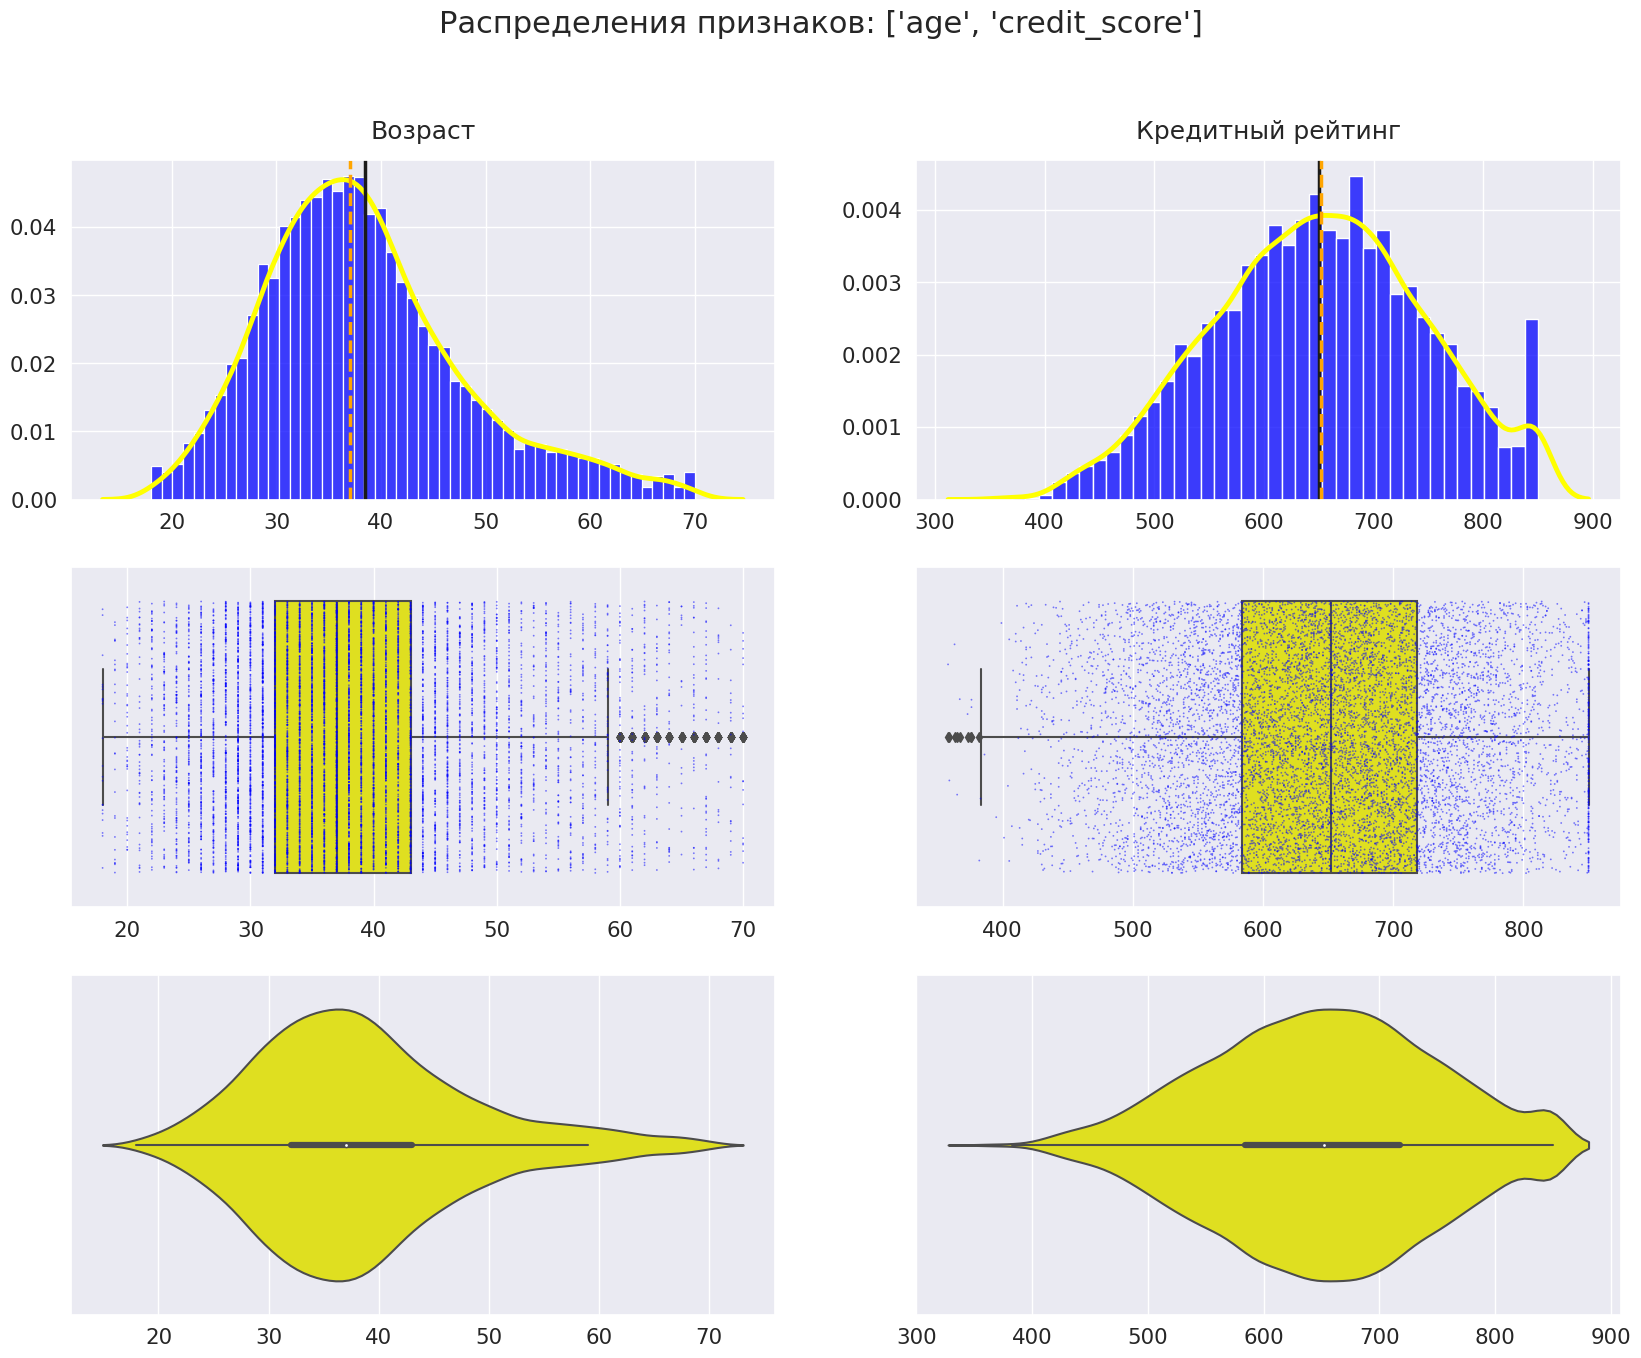

In [46]:
numerical = ['age', 'credit_score']

plots_numerics(data=df,
               x=numerical,
               xlabel=None,
               ylabel=None,
               title={'age': 'Возраст',
                      'credit_score': 'Кредитный рейтинг'},
               suptitle=(f'Распределения признаков: {numerical}'),
               nrows=3,
               ncols=2,
               figsize=(20, 15))

**Переместим данные признаков `row_number`, `customer_id`, `surname` в датафрейм `df_client_id`.**

In [47]:
df_client_id = df[['row_number', 'customer_id', 'surname']]

In [48]:
df = df.drop(columns=['row_number', 'customer_id', 'surname'])

**Преобразуем категориальные признаки `geography`, `gender` в численные, техникой прямого кодирования `pd.get_dummies`.**  
**Сохраним данные в датафрейм `df_ohe`.**

**Заполним пропуски в признаке `tenure`.**
**Заполнять пропуски будем на основе предсказания модели `KNeighborsRegressor`.**

In [49]:
"""
На вход функции предаем:
    data - датафрейм;
    target_col - целевой значение, в котором есть пропуски, но от которых необходимо избавится;
    features - признаки на которых будем обучать модель.
"""

def imputer_rfr(data, target_col, features):
    #Сделаем копию датасета, чтобы ничего не поломать в исходном
    data = data.copy()
    
    #Берем только те признаки на которых будем обучаться и целевое значение (там где есть пропуски)
    data = data[features + [target_col]]

    #train - обучающая выборка, там где в target_col (целовом значении) пропусков нет
    train = data[~data[target_col].isna()]

    #predict_data - данные для предсказания, где в target_col (целовом значении) пропуски имеются
    predict_data = data[data[target_col].isna()]

    #Обучающую выборку разбиваем на X - признаки, y - целевое значение
    X = train.drop(columns=target_col)
    y = train[target_col]
    
    #X, y разбиваем на обучающую и валидационную
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=42)
    
    X_train_ohe = pd.get_dummies(X_train, drop_first=False)
    X_test_ohe = pd.get_dummies(X_test, drop_first=False)
    
    #Обучим модель. В этом случае модель будет обучаться восстанавливать признак в y_train основываясь на признаках X_train где пропусков нет
    
    model = KNeighborsRegressor(n_jobs=-1)

    param_search = {
        'n_neighbors': list(range(2, 14)),
    }

    gs = GridSearchCV(estimator=model,
                      cv=5,
                      param_grid=param_search,
                      scoring='r2')
    
    gs.fit(X_train_ohe, y_train)
    
    print(gs.best_estimator_)
    
    model = gs.best_estimator_
    
    pred_train = model.predict(X_train_ohe)
    pred_test = model.predict(X_test_ohe)
    
    print(f'r2 на train: {r2_score(y_train, pred_train):.3f}')
    print(f'r2 на test: {r2_score(y_test, pred_test):.3f}')

    #Делаем предсказания обученной модели на данных где пропуски есть. Не забудем исключить целевое значение target_col
    predict_data_ohe = pd.get_dummies(predict_data, drop_first=False)
    pred = model.predict(predict_data_ohe.drop(columns=target_col))

    #Добавим список предсказаний pred. Логической индексацией ищем где у нас есть пропуски (target_col), берем его и заполняем списком предсказаний list(pred)
    data.loc[data[target_col].isna(), target_col] = list(pred)

    #На выходе получаем обученную модель и датафрейм
    return model, data

In [50]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [51]:
#Сохраним обучающие признаки в переменную
missing_val_features = ['credit_score', 'age', 'balance', 'num_of_products', 'has_cr_card',\
    'is_active_member', 'estimated_salary', 'exited','geography', 'gender']

In [52]:
%%time
model, new_df = imputer_rfr(df, 'tenure', features=missing_val_features)

KNeighborsRegressor(n_jobs=-1, n_neighbors=13)
r2 на train: 0.071
r2 на test: -0.061
CPU times: user 2.46 s, sys: 238 ms, total: 2.7 s
Wall time: 5.17 s


**`r2` метрики оказались очень далеки от идеала. Попытка модели `KNeighborsRegressor` выявить закономерности и заполнить пропуски признаем неуспешной.**

~~**Избавимся от пропусков в признаке `tenure` путём их удаления.**~~

**Избавимся от пропусков в признаке `tenure` путём заполнения их `медианой`.**

In [53]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())

In [54]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

In [55]:
print(f'\nКоличество строк: {df.shape[0]}\nКоличество колонок: {df.shape[1]}\n')


Количество строк: 9861
Количество колонок: 11



**Разделим данные на `признаки` и `целевой признак`:**  
* `X` — «признаки»;
* `y` — «целевой признак».

In [56]:
X = df.drop(['exited'], axis=1)
print(X.shape)

(9861, 10)


In [57]:
y = df['exited']
print(y.shape)

(9861,)


**Разделим полученные данные в переменных `X`, `y` на `обучающую` и `тестовую` выборки в пропорции `75`:`25`.**

**Данные запишем в новые переменные:**  

`X_train` - `75%`  
`X_test` - `25%`  
`y_train` - `75%`  
`y_test` - `25%`  

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

**Посмотрим на полученные данные.**

In [59]:
print(X_train.shape, X_test.shape)

(7395, 10) (2466, 10)


In [60]:
X_train.head(3)

credit_score geography  gender  age  tenure    balance  num_of_products  \
4518           850     Spain  Female   29    5.00       0.00                2   
4600           574    France  Female   34    5.00 112,324.45                2   
3156           692   Germany  Female   41    8.00 130,701.29                1   

      has_cr_card  is_active_member  estimated_salary  
4518            1                 0         23,237.25  
4600            1                 1         17,993.43  
3156            1                 0         59,354.24

In [61]:
print(y_train.shape, y_test.shape)

(7395,) (2466,)


**Преобразуем категориальные признаки `geography`, `gender` в численные, техникой прямого кодирования `OneHotEncoder`.**  
**Сохраним данные в датафреймы `X_train_encoded` и `X_test_encoded`.**

In [62]:
def one_hot_encoder(fit_data, conversion_data):

    object_cols = fit_data.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(fit_data[object_cols])
    
    encoded_data = encoder.transform(conversion_data[object_cols])
    
    encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names(object_cols))
    encoded_data.index = conversion_data.index
    new_df = pd.concat([conversion_data.drop(object_cols, axis=1), encoded_data], axis=1)
    
    return new_df

In [63]:
X_train_encoded = one_hot_encoder(fit_data=X_train, conversion_data=X_train)

In [64]:
X_test_encoded = one_hot_encoder(fit_data=X_train, conversion_data=X_test)

In [65]:
X_train_encoded.shape

(7395, 13)

In [66]:
X_test_encoded.shape

(2466, 13)

In [67]:
X_train_encoded.columns = X_train_encoded.columns.str.lower()

In [68]:
X_test_encoded.columns = X_test_encoded.columns.str.lower()

In [69]:
X_train_encoded.head()

credit_score  age  tenure    balance  num_of_products  has_cr_card  \
4518           850   29    5.00       0.00                2            1   
4600           574   34    5.00 112,324.45                2            1   
3156           692   41    8.00 130,701.29                1            1   
8739           518   59    5.00 138,772.15                1            0   
3085           734   54    3.00       0.00                1            1   

      is_active_member  estimated_salary  geography_france  geography_germany  \
4518                 0         23,237.25              0.00               0.00   
4600                 1         17,993.43              1.00               0.00   
3156                 0         59,354.24              0.00               1.00   
8739                 1        123,872.00              1.00               0.00   
3085                 0        130,805.54              1.00               0.00   

      geography_spain  gender_female  gender_male  
4518             1.00           1.00         0.00  
4600             0.00           1.00         0.00  
3156             0.00           1.00         0.00  
8739             0.00           0.00         1.00  
3085             0.00           1.00         0.00

In [70]:
X_test_encoded.head()

credit_score  age  tenure    balance  num_of_products  has_cr_card  \
7071           698   63    5.00       0.00                1            1   
7716           684   32    9.00 100,249.41                2            0   
9881           687   40    1.00       0.00                2            1   
4623           709   24    3.00 110,949.41                1            1   
1053           600   50    6.00  94,684.27                1            1   

      is_active_member  estimated_salary  geography_france  geography_germany  \
7071                 1        173,576.71              0.00               0.00   
7716                 1         67,599.69              1.00               0.00   
9881                 0          8,207.36              0.00               0.00   
4623                 1        168,515.61              1.00               0.00   
1053                 1         50,488.91              0.00               0.00   

      geography_spain  gender_female  gender_male  
7071             1.00           1.00         0.00  
7716             0.00           0.00         1.00  
9881             1.00           1.00         0.00  
4623             0.00           1.00         0.00  
1053             1.00           1.00         0.00

**Для `линейных моделей ML обучения` преобразуем масштаб количественных признаков `credit_score`, `age`, `tenure`, `balance`, `estimated_salary` методом стандартизации.**  
**Данные запишем в новые переменные `X_train_scaled` и `X_test_scaled`.**

In [71]:
X_train_scaled, X_test_scaled = X_train_encoded.copy(), X_test_encoded.copy()

In [72]:
features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

In [73]:
scaler = StandardScaler()

In [74]:
X_train_scaled[features] = scaler.fit_transform(X_train_scaled[features])

In [75]:
X_test_scaled[features] = scaler.fit_transform(X_test_scaled[features])

In [76]:
X_train_scaled.head(3)

credit_score   age  tenure  balance  num_of_products  has_cr_card  \
4518          2.08 -0.98   -0.00    -1.24                2            1   
4600         -0.79 -0.47   -0.00     0.57                2            1   
3156          0.44  0.26    1.09     0.86                1            1   

      is_active_member  estimated_salary  geography_france  geography_germany  \
4518                 0             -1.33              0.00               0.00   
4600                 1             -1.43              1.00               0.00   
3156                 0             -0.71              0.00               1.00   

      geography_spain  gender_female  gender_male  
4518             1.00           1.00         0.00  
4600             0.00           1.00         0.00  
3156             0.00           1.00         0.00

In [77]:
X_test_scaled.head(3)

credit_score   age  tenure  balance  num_of_products  has_cr_card  \
7071          0.47  2.54    0.00    -1.19                1            1   
7716          0.32 -0.64    1.46     0.40                2            0   
9881          0.35  0.18   -1.45    -1.19                2            1   

      is_active_member  estimated_salary  geography_france  geography_germany  \
7071                 1              1.28              0.00               0.00   
7716                 1             -0.57              1.00               0.00   
9881                 0             -1.61              0.00               0.00   

      geography_spain  gender_female  gender_male  
7071             1.00           1.00         0.00  
7716             0.00           0.00         1.00  
9881             1.00           1.00         0.00

In [78]:
print(X_train_scaled.shape, X_test_scaled.shape)

(7395, 13) (2466, 13)


## Исследование задачи

### Исследуем баланс классов подробнее. Взглянем еще раз на распределение количественных признаков.

In [79]:
def histplots_numerics(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, figsize=(3 , 3)):

    plt.figure(figsize=figsize)
    
    for i in enumerate(x):
        plt.subplot(nrows, ncols, i[0] + 1)
        sns.histplot(data[i[1]],
                     color='blue',
                     kde=True)
        plt.xlabel(i[1])
        plt.ylabel(ylabel)
        plt.axvline(data[i[1]].mean(), label='mean', c='k', ls='-', lw=3.5)
        plt.axvline(data[i[1]].median(), label='median', c='orange', ls='--', lw=3.5)
        plt.title(title[i[1]], fontsize=18, pad=5)

    plt.suptitle(suptitle, fontsize=22)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
    plt.show()

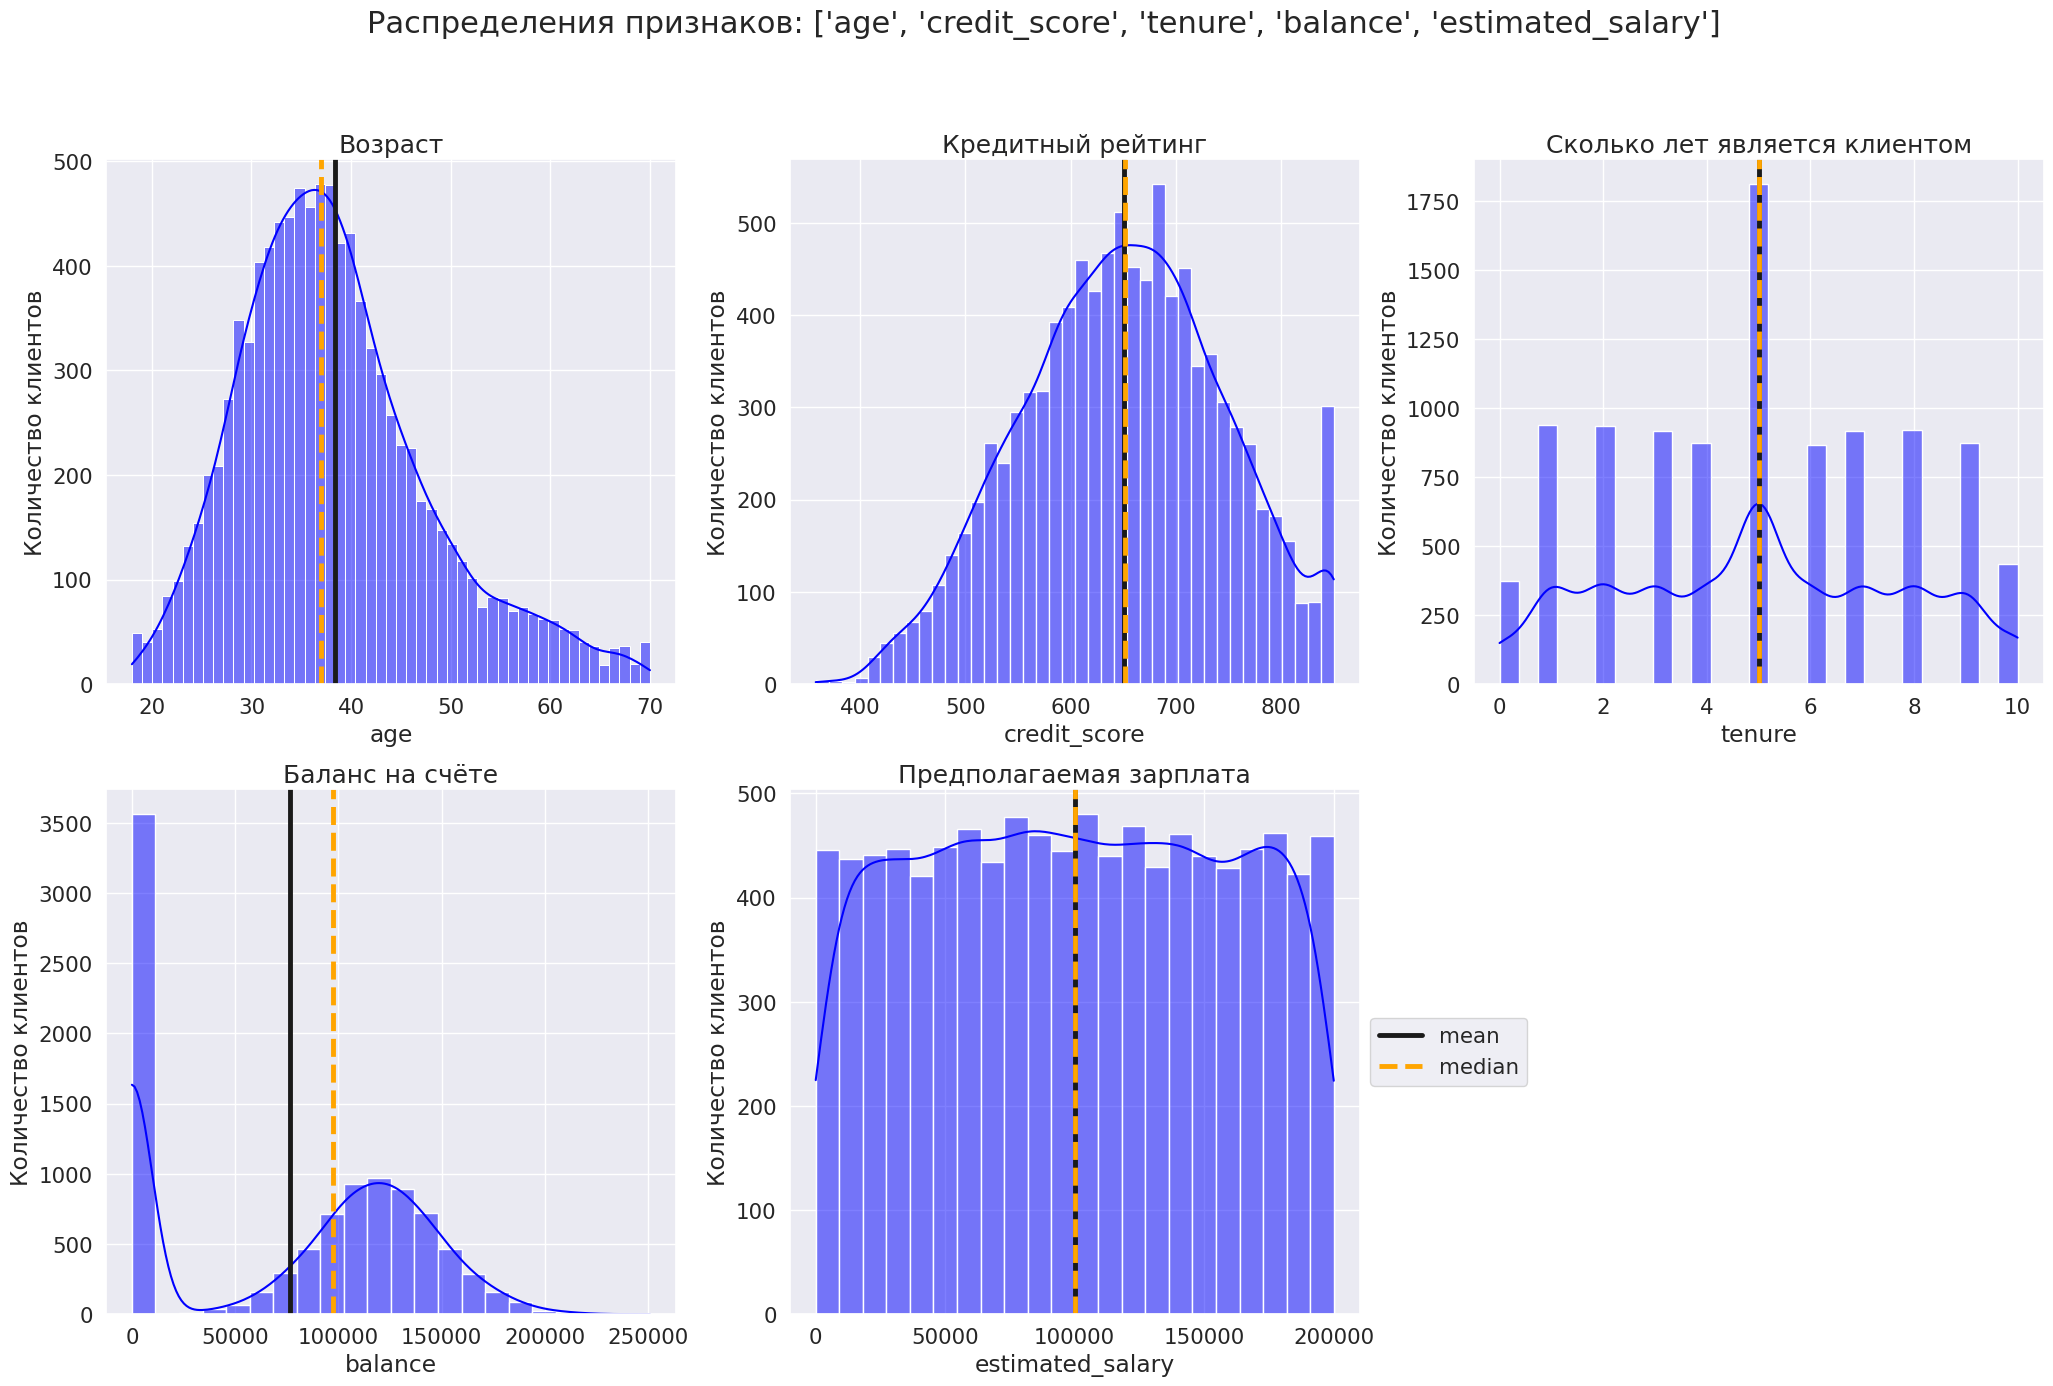

In [80]:
numerical = ['age', 'credit_score', 'tenure', 'balance', 'estimated_salary']

histplots_numerics(data=df,
                   x=numerical,
                   xlabel=None,
                   ylabel='Количество клиентов',
                   title={'age': 'Возраст',
                          'credit_score': 'Кредитный рейтинг',
                          'tenure': 'Сколько лет является клиентом',
                          'balance': 'Баланс на счёте',
                          'estimated_salary': 'Предполагаемая зарплата'},
                   suptitle=(f'Распределения признаков: {numerical}'),
                   nrows=2,
                   ncols=3,
                   figsize=(25, 15))

**В признаке `age` заметны выбросы, медиана и средняя смещены вправо к выбросам. В признаках `tenure`, `estimated_salary` аномалий не замечено.**  
**В признаке `credit_score` на графике `boxplot`заметны выбросы. Признак `balance` распределен нормально, если не учитывать клиентов с нулевым балансом, которые сильно перетягивают на себя среднюю и медиану.**

**Взглянем еще раз на распределение категориальных признаков.**

In [81]:
def countplot_categories(data, x, xlabel=None, ylabel=None, title=None, suptitle=None, nrows=1, ncols=1, hue=None, figsize=(3 , 3)):
    
    plt.figure(figsize=figsize)
    
    for i in enumerate(x):
        palette = {0: 'green', 1: 'red'}
        plt.subplot(nrows, ncols, i[0] + 1)
        sns.countplot(data=data, x=i[1], hue=hue, dodge=False, saturation=1, palette=palette)
        plt.xlabel(i[1])
        plt.ylabel(ylabel)
        plt.title(title[i[1]], fontsize=18, pad=5)

    plt.suptitle(suptitle, fontsize=22)
    plt.show()

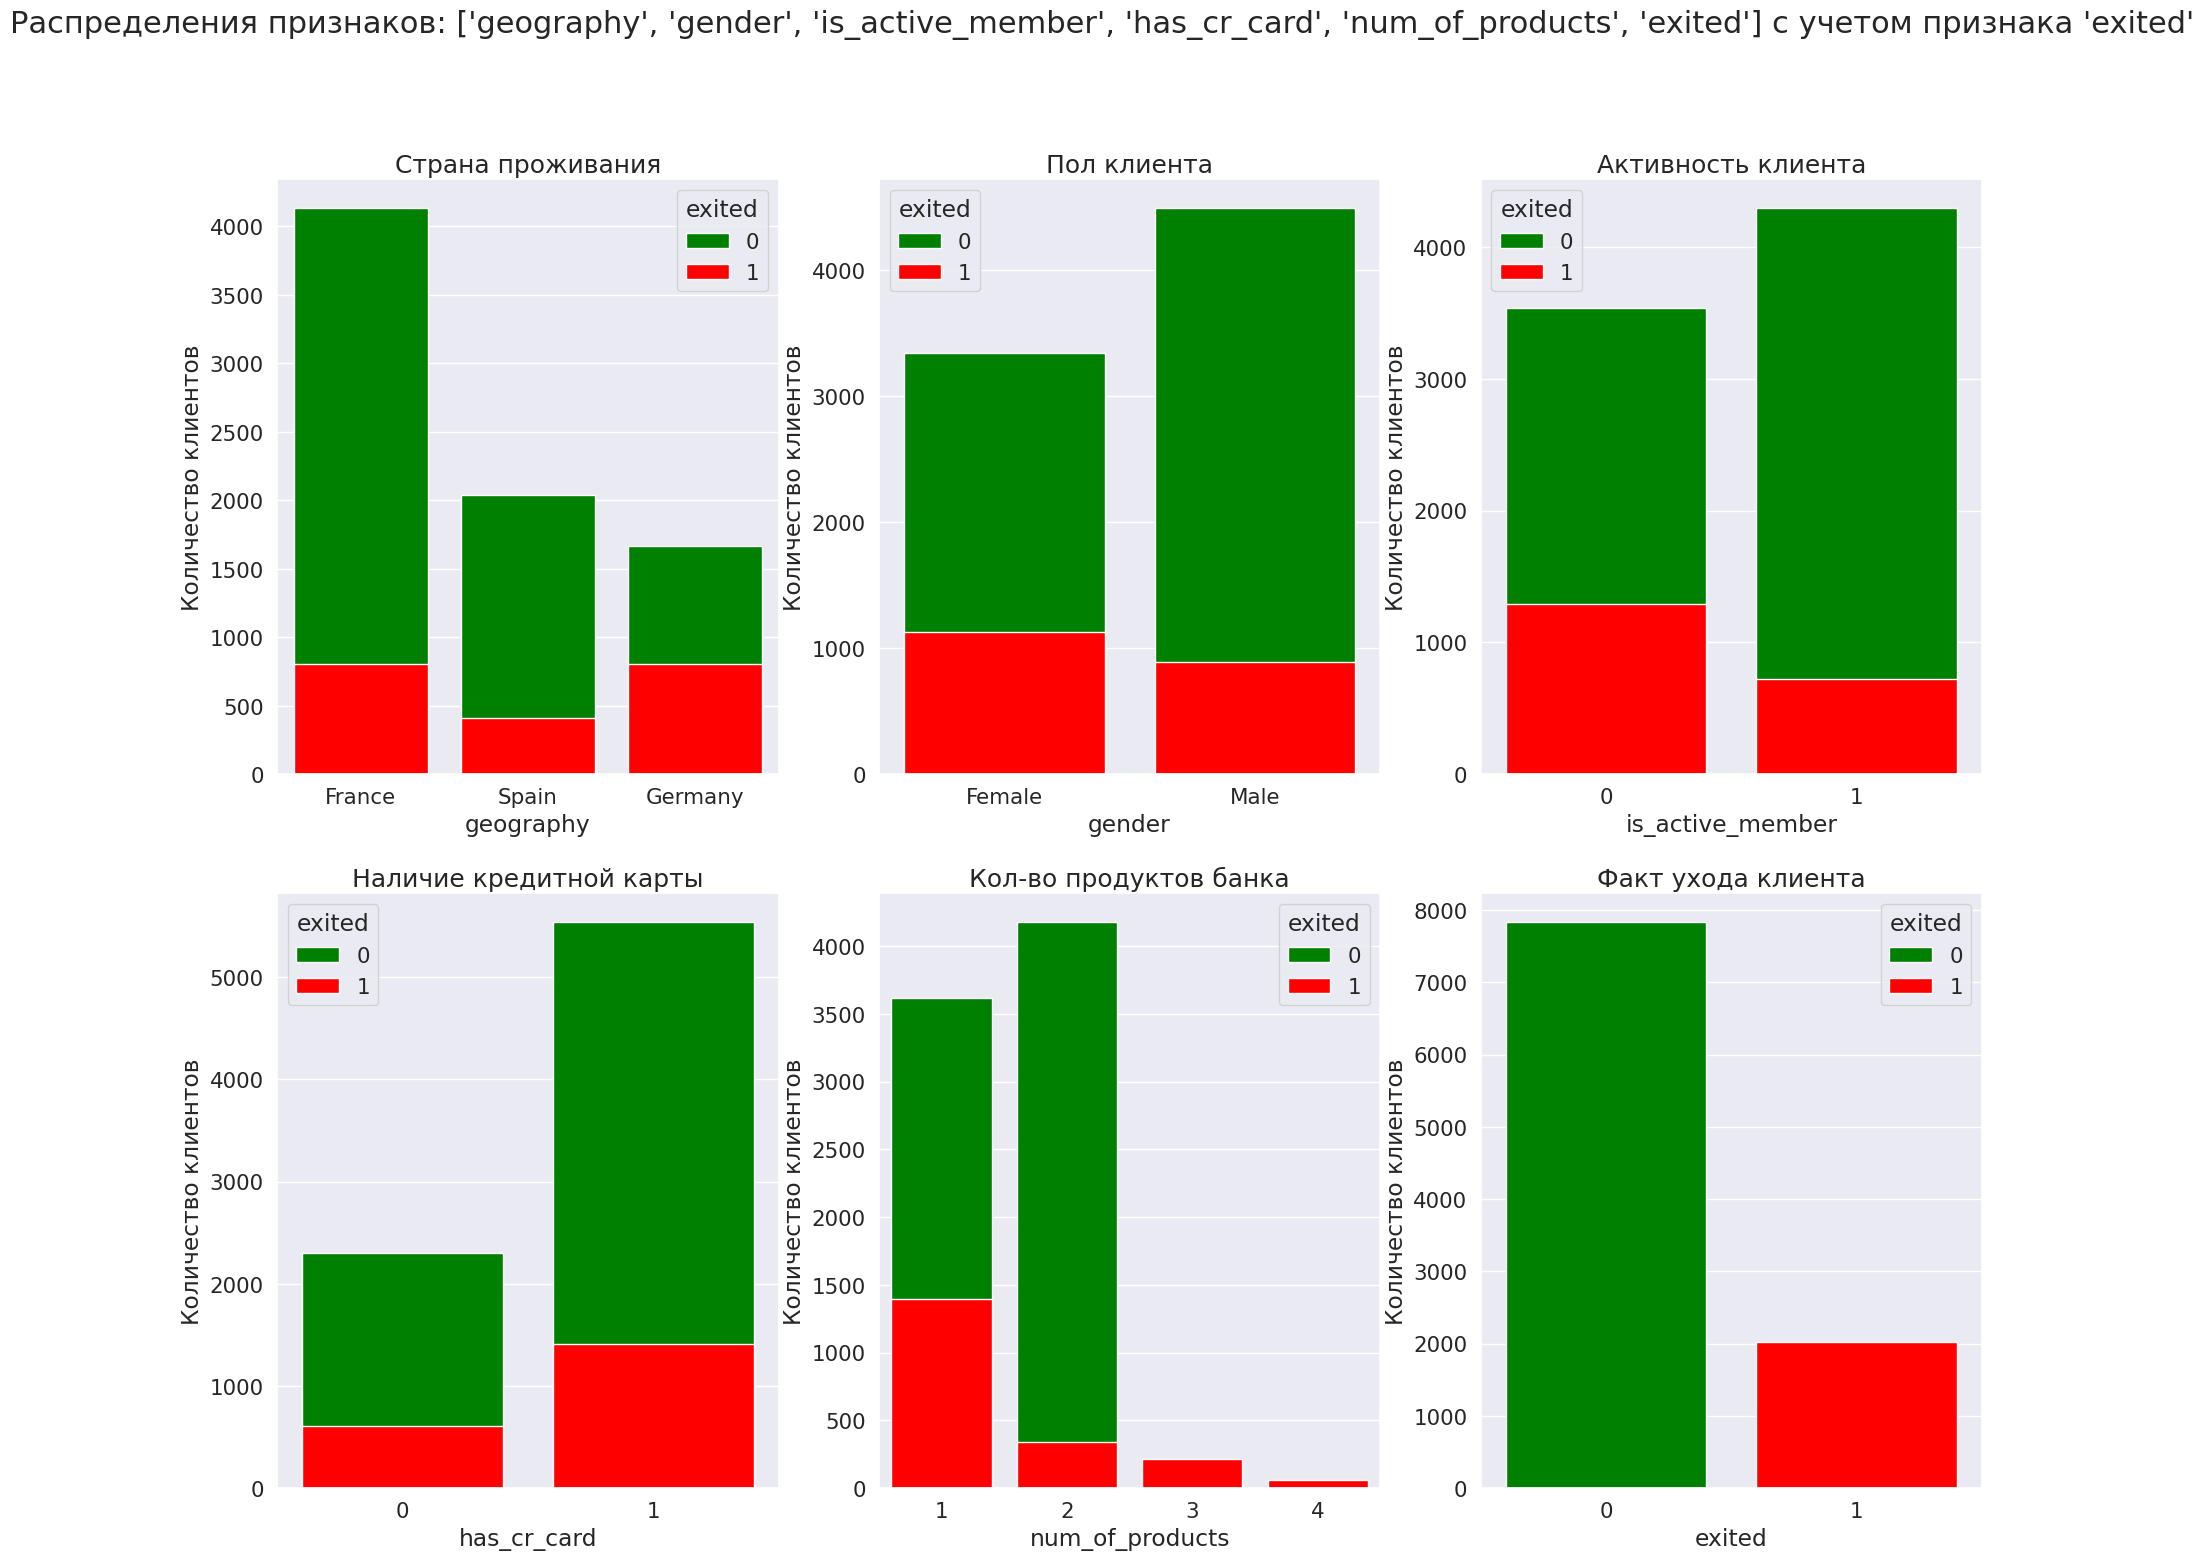

In [82]:
categories = ['geography', 'gender', 'is_active_member', 'has_cr_card', 'num_of_products', 'exited']

hue='exited'

countplot_categories(data=df,
                     x=categories,
                     xlabel=None,
                     ylabel='Количество клиентов',
                     hue=hue,
                     title={'geography': 'Страна проживания',
                            'gender': 'Пол клиента',
                            'is_active_member': 'Активность клиента',
                            'has_cr_card': 'Наличие кредитной карты',
                            'num_of_products': 'Кол-во продуктов банка',
                            'exited': 'Факт ухода клиента'},
                     suptitle=(f'Распределения признаков: {categories} c учетом признака \'{hue}\''),
                     nrows=2,
                     ncols=3,
                     figsize=(22, 17))

**Явный дисбаланс классов в признаке `exited`, несбалансирован примерно 4:1.**  
**Дисбаланс классов в признаках `has_cr_card`, `num_of_products`. Интересный факт, те, у кого `3` или `4` продукта в `100%` перестали пользоваться продуктом.**  
**Дисбаланс классов в признаке `geography`, клиентов с `Франции` примерно в два раза больше по сравнению с остальными.**  
**Классы в признаках `is_active_member` и `gender` выглядят относительно сбалансированно.**  

### Изучим модели без учёта дисбаланса

**Обучим модель `DecisionTreeClassifier`.**

In [83]:
model = DecisionTreeClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_encoded` и `y_train`.**

In [84]:
%%time

gs.fit(X_train_encoded, y_train)
results_model_DecisionTreeClassifier = gs.cv_results_

CPU times: user 12.2 s, sys: 1.21 s, total: 13.4 s
Wall time: 2min 53s


In [85]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 9,
 'min_samples_split': 2}

In [86]:
results_model_DecisionTreeClassifier['mean_test_F1'][gs.best_index_]

0.5739088198896384

In [87]:
results_model_DecisionTreeClassifier['mean_test_ROC_AUC'][gs.best_index_]

0.8413273725331717

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_DecisionTreeClassifier.joblib`.**

In [88]:
joblib.dump(gs.best_estimator_, 'model_DecisionTreeClassifier.joblib')

['model_DecisionTreeClassifier.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `DecisionTreeClassifier` `0.58`;  
>2. Наилучшая метрика `ROC_AUC` для `DecisionTreeClassifier` `0.84`.  

**Попробуем улучшить результат на других моделях.**



**Обучим модель `CatBoostClassifier`.**

In [89]:
model = CatBoostClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'depth': list(range(3, 11)),
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'iterations': list(range(10, 110, 10)),
    'logging_level': ['Silent']
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_encoded` и `y_train`.**

In [90]:
%%time

gs.fit(X_train_encoded, y_train)
results_model_CatBoostClassifier = gs.cv_results_

CPU times: user 6.68 s, sys: 883 ms, total: 7.56 s
Wall time: 6min 5s


In [91]:
gs.best_params_

{'depth': 8,
 'iterations': 80,
 'learning_rate': 0.04,
 'logging_level': 'Silent'}

In [92]:
results_model_CatBoostClassifier['mean_test_F1'][gs.best_index_]

0.5729712699960852

In [93]:
results_model_CatBoostClassifier['mean_test_ROC_AUC'][gs.best_index_]

0.8644243505983251

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_CatBoostClassifier.joblib`.**

In [94]:
joblib.dump(gs.best_estimator_, 'model_CatBoostClassifier.joblib')

['model_CatBoostClassifier.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `CatBoostClassifier` `0.57`;  
>2. Наилучшая метрика `ROC_AUC` для `CatBoostClassifier` `0.86`.  

**Попробуем улучшить результат на других моделях.**

**Обучим модель `LogisticRegression` на стандартизированной выборке `X_train_scaled`.**

In [95]:
model = LogisticRegression(max_iter=1000, random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_scaled` и `y_train`.**

In [96]:
%%time

gs.fit(X_train_scaled, y_train)
results_model_LogisticRegression = gs.cv_results_

CPU times: user 14.5 s, sys: 1.51 s, total: 16 s
Wall time: 2min 54s


In [97]:
gs.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [98]:
results_model_LogisticRegression['mean_test_F1'][gs.best_index_]

0.366260054205224

In [99]:
results_model_LogisticRegression['mean_test_ROC_AUC'][gs.best_index_]

0.7761820569812083

**Низкая метрика `F1`. Добавим параметр модели `class_weight='balanced'` и посмотрим как изменится результат.**

In [100]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

In [101]:
%%time

gs.fit(X_train_scaled, y_train)
results_model_LogisticRegression_balanced = gs.cv_results_

CPU times: user 20.3 s, sys: 2.62 s, total: 22.9 s
Wall time: 3min 6s


In [102]:
gs.best_params_

{'C': 1, 'solver': 'liblinear'}

In [103]:
results_model_LogisticRegression_balanced['mean_test_F1'][gs.best_index_]

0.5059547954996708

In [104]:
results_model_LogisticRegression_balanced['mean_test_ROC_AUC'][gs.best_index_]

0.7778277317527672

**Метрика `F1` при указании параметра `class_weight='balanced'` оказалась выше.**

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_LogisticRegression_balanced.joblib`.**

In [105]:
joblib.dump(gs.best_estimator_, 'model_LogisticRegression_balanced.joblib')

['model_LogisticRegression_balanced.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `LogisticRegression` `0.36`;  
>2. Наилучшая метрика `F1` для `LogisticRegression` с параметром `class_weight='balanced'` равна `0.51`;  
>3. Наилучшая метрика `ROC_AUC` для `LogisticRegression` `0.78`.

**Промежуточный вывод:**  

> Наилучшей метрики `F1` удалось добится для модели `CatBoostClassifier` с результатом `0.57`.

## Борьба с дисбалансом

### Upsampling

In [106]:
def upsample(X, y, repeat):
    
    X_zeros = X.loc[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled = shuffle(X_upsampled, random_state=42)
    y_upsampled = shuffle(y_upsampled, random_state=42)
    
    return X_upsampled, y_upsampled

In [107]:
X_train_upsampled, y_train_upsampled = upsample(X_train_encoded, y_train, 5)

print(X_train_upsampled.shape)
print(y_train_upsampled.shape)

(13455, 13)
(13455,)


In [108]:
X_test_upsampled, y_test_upsampled = upsample(X_test_encoded, y_test, 5)

print(X_test_upsampled.shape)
print(y_test_upsampled.shape)

(4486, 13)
(4486,)


**Для `линейных моделей ML обучения` отдельно сделаем upsample для стандартизированных выборок `X_train_scaled` и `X_test_scaled`.**

In [109]:
X_train_scaled_upsampled, y_train_scaled_upsampled = upsample(X_train_scaled, y_train, 5)

print(X_train_scaled_upsampled.shape)
print(y_train_scaled_upsampled.shape)

(13455, 13)
(13455,)


In [110]:
X_test_scaled_upsampled, y_test_scaled_upsampled = upsample(X_test_scaled, y_test, 5)

print(X_test_scaled_upsampled.shape)
print(y_test_scaled_upsampled.shape)

(4486, 13)
(4486,)


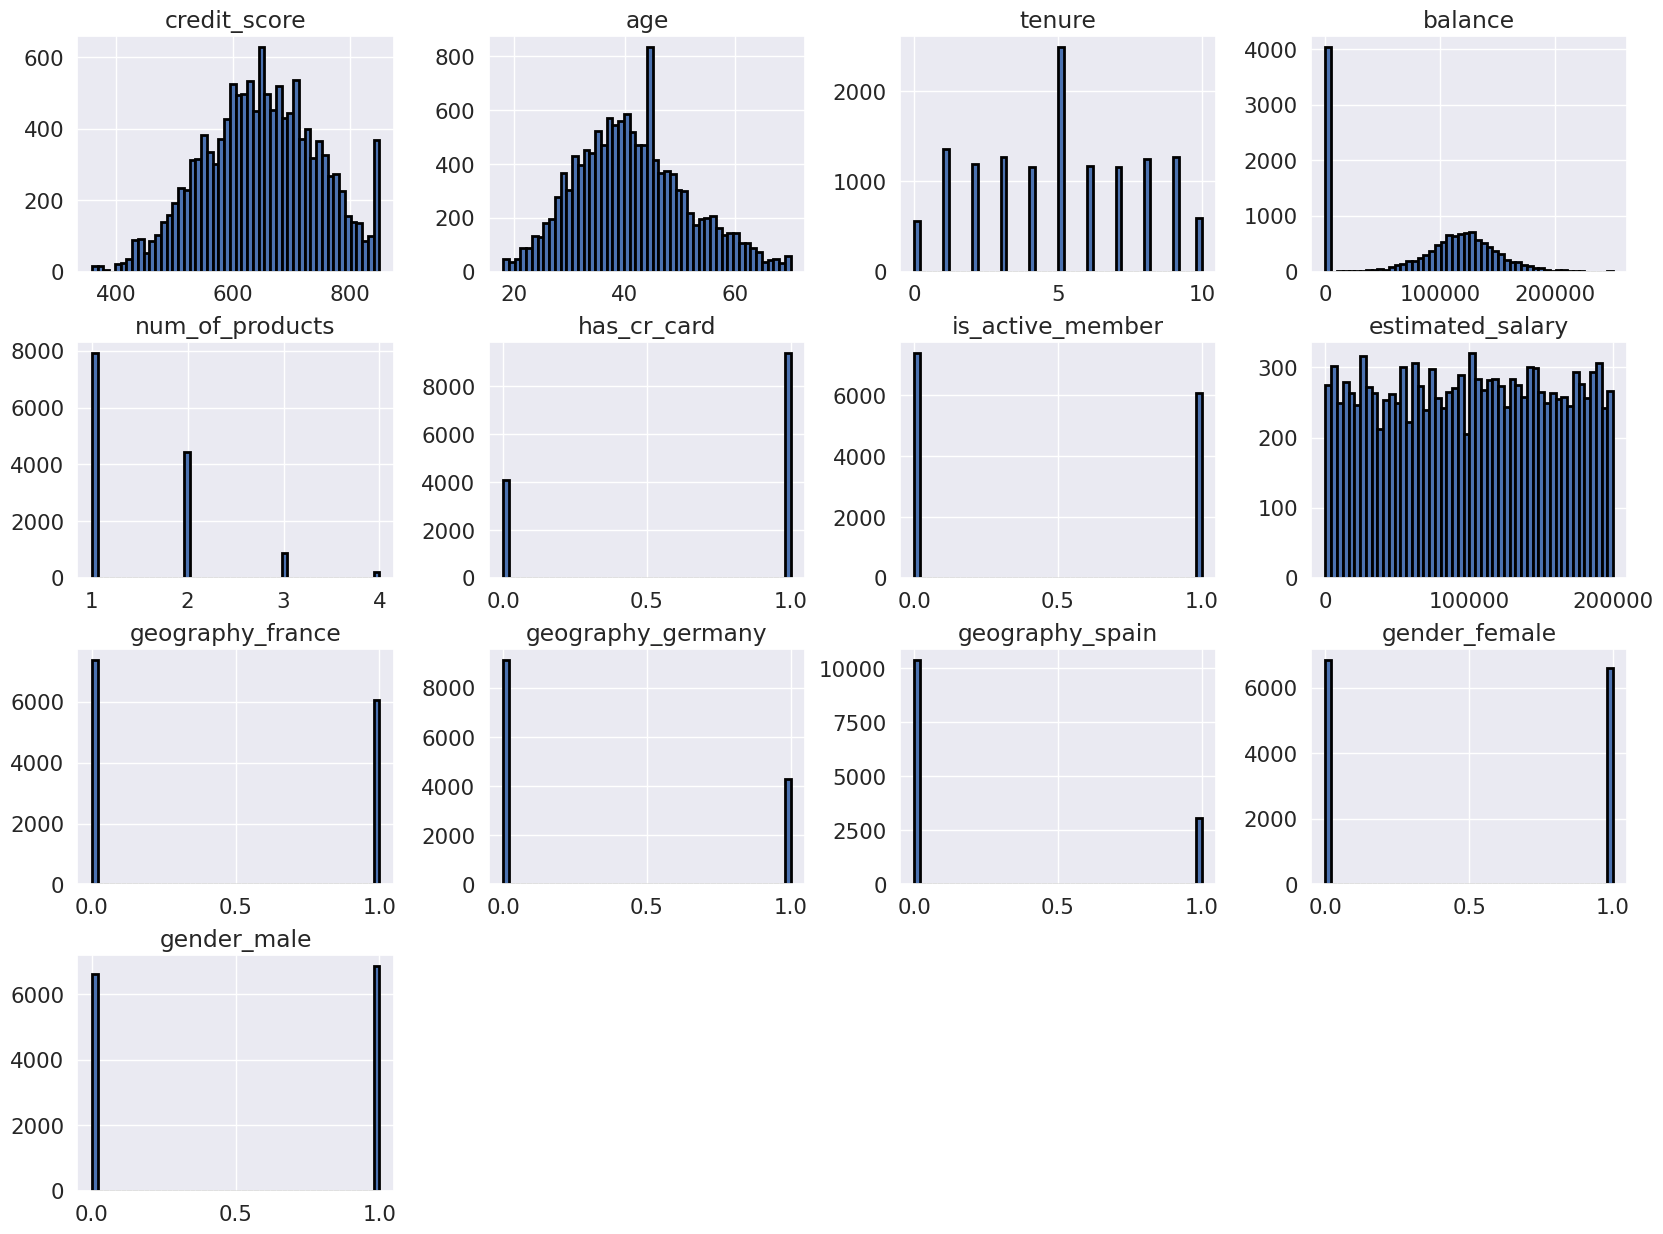

In [111]:
X_train_upsampled.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

**Обучим модель `DecisionTreeClassifier` на `upsampled` выборках.**

In [112]:
model = DecisionTreeClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_upsampled` и `y_train_upsampled`.**

In [113]:
%%time

gs.fit(X_train_upsampled, y_train_upsampled)
results_model_DecisionTreeClassifier_upsampled = gs.cv_results_

CPU times: user 12.7 s, sys: 1.87 s, total: 14.6 s
Wall time: 4min 23s


In [114]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [115]:
results_model_DecisionTreeClassifier_upsampled['mean_test_F1'][gs.best_index_]

0.853939954903459

In [116]:
results_model_DecisionTreeClassifier_upsampled['mean_test_ROC_AUC'][gs.best_index_]

0.9016618957814149

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_DecisionTreeClassifier_upsampled.joblib`.**

In [117]:
joblib.dump(gs.best_estimator_, 'model_DecisionTreeClassifier_upsampled.joblib')

['model_DecisionTreeClassifier_upsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `DecisionTreeClassifier` `0.86`;  
>2. Наилучшая метрика `ROC_AUC` для `DecisionTreeClassifier` `0.90`.  

**Попробуем улучшить результат на других моделях.**



**Обучим модель `CatBoostClassifier` на `upsampled` выборках.**

In [118]:
model = CatBoostClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'depth': list(range(3, 11)),
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'iterations': list(range(10, 110, 10)),
    'logging_level': ['Silent']
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_upsampled` и `y_train_upsampled`.**

In [119]:
%%time

gs.fit(X_train_upsampled, y_train_upsampled)
results_model_CatBoostClassifier_upsampled = gs.cv_results_

CPU times: user 9.93 s, sys: 1.71 s, total: 11.6 s
Wall time: 7min 49s


In [120]:
gs.best_params_

{'depth': 10,
 'iterations': 100,
 'learning_rate': 0.04,
 'logging_level': 'Silent'}

In [121]:
results_model_CatBoostClassifier_upsampled['mean_test_F1'][gs.best_index_]

0.8397375443601071

In [122]:
results_model_CatBoostClassifier_upsampled['mean_test_ROC_AUC'][gs.best_index_]

0.904552996115938

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_CatBoostClassifier_upsampled.joblib`.**

In [123]:
joblib.dump(gs.best_estimator_, 'model_CatBoostClassifier_upsampled.joblib')

['model_CatBoostClassifier_upsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `CatBoostClassifier` `0.85`;  
>2. Наилучшая метрика `ROC_AUC` для `CatBoostClassifier` `0.90`.  

**Попробуем улучшить результат на других моделях.**

**Обучим модель `LogisticRegression` на стандартизированной `upsampled` выборках.**

In [124]:
model = LogisticRegression(max_iter=1000, random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_scaled_upsampled` и `y_train_scaled_upsampled`.**

In [125]:
%%time

gs.fit(X_train_scaled_upsampled, y_train_scaled_upsampled)
results_model_LogisticRegression_upsampled = gs.cv_results_

CPU times: user 21.4 s, sys: 2.76 s, total: 24.2 s
Wall time: 4min 1s


In [126]:
gs.best_params_

{'C': 2, 'solver': 'lbfgs'}

In [127]:
results_model_LogisticRegression_upsampled['mean_test_F1'][gs.best_index_]

0.7566782143128015

In [128]:
results_model_LogisticRegression_upsampled['mean_test_ROC_AUC'][gs.best_index_]

0.7795140432410588

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_LogisticRegression_upsampled.joblib`.**

In [129]:
joblib.dump(gs.best_estimator_, 'model_LogisticRegression_upsampled.joblib')

['model_LogisticRegression_upsampled.joblib']

**Добавим параметр модели `class_weight='balanced'` и посмотрим как изменится результат.**

In [130]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

In [131]:
%%time

gs.fit(X_train_scaled_upsampled, y_train_scaled_upsampled)
results_model_LogisticRegression_balanced_upsampled = gs.cv_results_

CPU times: user 20.7 s, sys: 2.55 s, total: 23.3 s
Wall time: 3min 56s


In [132]:
gs.best_params_

{'C': 2, 'solver': 'liblinear'}

In [133]:
results_model_LogisticRegression_balanced_upsampled['mean_test_F1'][gs.best_index_]

0.7327665258412044

In [134]:
results_model_LogisticRegression_balanced_upsampled['mean_test_ROC_AUC'][gs.best_index_]

0.7793527311914864

**Метрика `F1` при указании параметра `class_weight='balanced'` оказалась немного ниже.**

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_LogisticRegression_balanced_upsampled.joblib`.**

In [135]:
joblib.dump(gs.best_estimator_, 'model_LogisticRegression_balanced_upsampled.joblib')

['model_LogisticRegression_balanced_upsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `LogisticRegression` `0.76`;  
>2. Наилучшая метрика `F1` для `LogisticRegression` с параметром `class_weight='balanced'` равна `0.74`;  
>3. Наилучшая метрика `ROC_AUC` для `LogisticRegression` `0.78`.

**Промежуточный вывод для upsampled:**  

> Наилучшей метрики `F1` удалось добится для модели `DecisionTreeClassifier` с результатом `0.86`.

### Downsampling

In [136]:
def downsample(X, y, fraction):
    
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_sample = X_zeros.sample(frac=0.1, random_state=42)
    y_sample = y_zeros.sample(frac=0.1, random_state=42)
    
    X_downsampled = pd.concat([X_sample] + [X_ones])
    y_downsampled = pd.concat([y_sample] + [y_ones])
    
    X_downsampled = shuffle(X_downsampled, random_state=42)
    y_downsampled = shuffle(y_downsampled, random_state=42)

    return X_downsampled, y_downsampled

In [137]:
X_train_downsampled, y_train_downsampled = downsample(X_train_encoded, y_train, 0.1)

print(X_train_downsampled.shape)
print(y_train_downsampled.shape)

(2103, 13)
(2103,)


In [138]:
X_test_downsampled, y_test_downsampled = downsample(X_test_encoded, y_test, 0.1)

print(X_test_downsampled.shape)
print(y_test_downsampled.shape)

(701, 13)
(701,)


**Для `линейных моделей ML обучения` отдельно сделаем downsample для стандартизированных выборок `X_train_scaled` и `X_test_scaled`.**

In [139]:
X_train_scaled_downsampled, y_train_scaled_downsampled = downsample(X_train_scaled, y_train, 5)

print(X_train_scaled_downsampled.shape)
print(y_train_scaled_downsampled.shape)

(2103, 13)
(2103,)


In [140]:
X_test_scaled_downsampled, y_test_scaled_downsampled = downsample(X_test_scaled, y_test, 5)

print(X_test_scaled_downsampled.shape)
print(y_test_scaled_downsampled.shape)

(701, 13)
(701,)


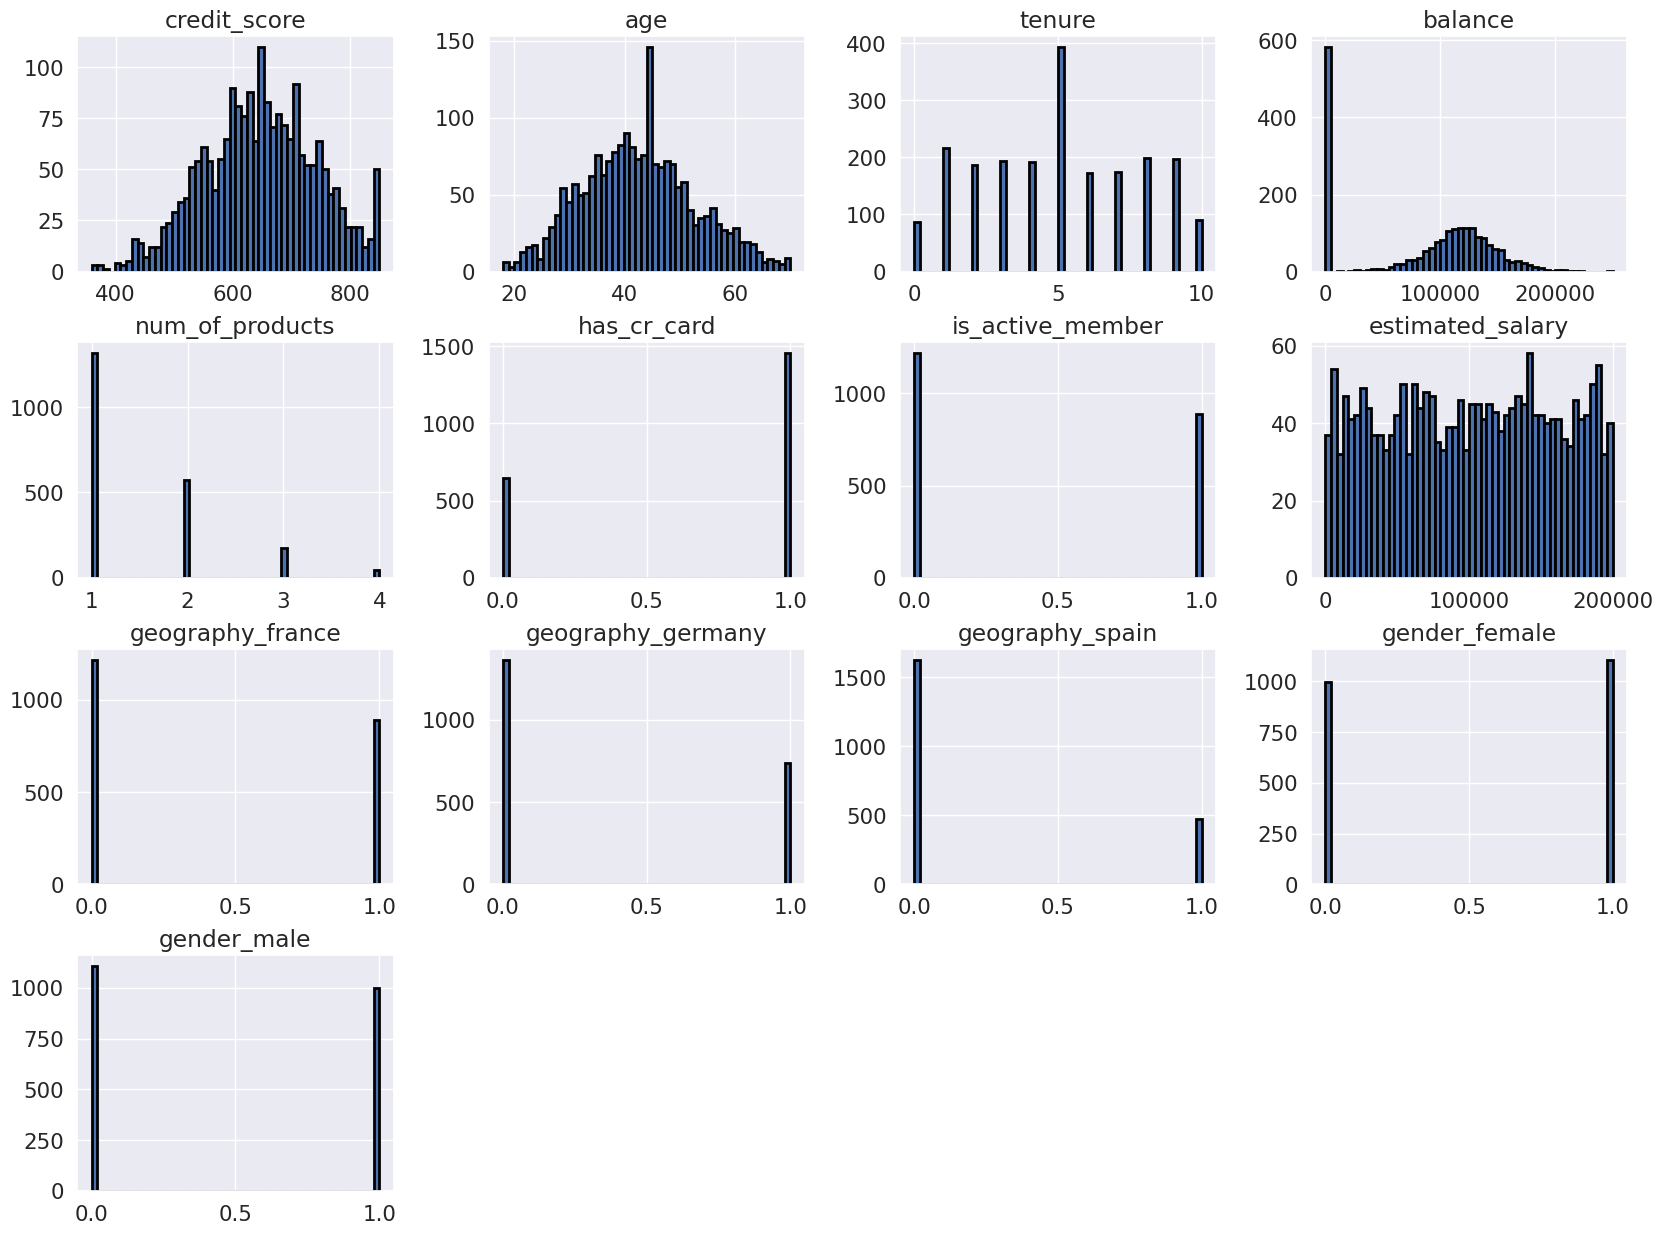

In [141]:
X_train_downsampled.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

**Обучим модель `DecisionTreeClassifier` на `downsampled` выборках.**

In [142]:
model = DecisionTreeClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_downsampled` и `y_train_downsampled`.**

In [143]:
%%time

gs.fit(X_train_downsampled, y_train_downsampled)
results_model_DecisionTreeClassifier_downsampled = gs.cv_results_

CPU times: user 10.7 s, sys: 380 ms, total: 11.1 s
Wall time: 1min 33s


In [144]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [145]:
results_model_DecisionTreeClassifier_downsampled['mean_test_F1'][gs.best_index_]

0.8696962305765219

In [146]:
results_model_DecisionTreeClassifier_downsampled['mean_test_ROC_AUC'][gs.best_index_]

0.817180051338467

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_DecisionTreeClassifier_downsampled.joblib`.**

In [147]:
joblib.dump(gs.best_estimator_, 'model_DecisionTreeClassifier_downsampled.joblib')

['model_DecisionTreeClassifier_downsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `DecisionTreeClassifier` `0.86`;  
>2. Наилучшая метрика `ROC_AUC` для `DecisionTreeClassifier` `0.81`;
>3. Метрика `F1` осталась прежней по сравнению с `upslampled` тоже равной `0.86`;
>4. Метрика `ROC_AUC` стала ниже по сравнению с `upslampled` равной `0.90`.

**Попробуем улучшить результат на других моделях.**

**Обучим модель `CatBoostClassifier` на `downsampled` выборках.**

In [148]:
model = CatBoostClassifier(random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'depth': list(range(3, 11)),
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'iterations': list(range(10, 110, 10)),
    'logging_level': ['Silent']
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_downsampled` и `y_train_downsampled`.**

In [149]:
%%time

gs.fit(X_train_downsampled, y_train_downsampled)
results_model_CatBoostClassifier_downsampled = gs.cv_results_

CPU times: user 3.78 s, sys: 301 ms, total: 4.08 s
Wall time: 4min 13s


In [150]:
gs.best_params_

{'depth': 4,
 'iterations': 90,
 'learning_rate': 0.04,
 'logging_level': 'Silent'}

In [151]:
results_model_CatBoostClassifier_downsampled['mean_test_F1'][gs.best_index_]

0.870430066882588

In [152]:
results_model_CatBoostClassifier_downsampled['mean_test_ROC_AUC'][gs.best_index_]

0.8473117107451728

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_CatBoostClassifier_downsampled.joblib`.**

In [153]:
joblib.dump(gs.best_estimator_, 'model_CatBoostClassifier_downsampled.joblib')

['model_CatBoostClassifier_downsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `CatBoostClassifier` `0.87`;  
>2. Наилучшая метрика `ROC_AUC` для `CatBoostClassifier` `0.84`;
>3. Метрика `F1` немного подросла по сравнению с `upslampled` равной `0.86`;
>4. Метрика `ROC_AUC` стала ниже по сравнению с `upslampled` равной `0.90`.

**Попробуем улучшить результат на других моделях.**

**Обучим модель `LogisticRegression` на стандартизированной `downsampled` выборках.**

In [154]:
model = LogisticRegression(max_iter=1000, random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

**Обучим модель на выборках `X_train_scaled_downsampled` и `y_train_scaled_downsampled`.**

In [155]:
%%time

gs.fit(X_train_scaled_downsampled, y_train_scaled_downsampled)
results_model_LogisticRegression_downsampled = gs.cv_results_

CPU times: user 12.2 s, sys: 524 ms, total: 12.7 s
Wall time: 1min 46s


In [156]:
gs.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [157]:
results_model_LogisticRegression_downsampled['mean_test_F1'][gs.best_index_]

0.8448048800484459

In [158]:
results_model_LogisticRegression_downsampled['mean_test_ROC_AUC'][gs.best_index_]

0.7589323339113572

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_LogisticRegression_downsampled.joblib`.**

In [159]:
joblib.dump(gs.best_estimator_, 'model_LogisticRegression_downsampled.joblib')

['model_LogisticRegression_downsampled.joblib']

**Низкая метрика `F1`. Добавим параметр модели `class_weight='balanced'` и посмотрим как изменится результат.**

In [160]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

scoring = {'F1': 'f1',
           'ROC_AUC': 'roc_auc'}

param_search = {
    'solver': ['lbfgs', 'liblinear'],
    'C': list(range(1, 1_001)),
}

gs = GridSearchCV(estimator=model,
                  cv=5,
                  param_grid=param_search,
                  scoring=scoring,
                  refit='F1',
                  n_jobs=-1,
                  return_train_score=True)

In [161]:
%%time

gs.fit(X_train_scaled_downsampled, y_train_scaled_downsampled)
results_model_LogisticRegression_balanced_downsampled = gs.cv_results_

CPU times: user 12.2 s, sys: 535 ms, total: 12.7 s
Wall time: 1min 46s


In [162]:
gs.best_params_

{'C': 2, 'solver': 'lbfgs'}

In [163]:
results_model_LogisticRegression_balanced_downsampled['mean_test_F1'][gs.best_index_]

0.7598575838907069

In [164]:
results_model_LogisticRegression_balanced_downsampled['mean_test_ROC_AUC'][gs.best_index_]

0.7585972808493366

**Метрика `F1` при указании параметра `class_weight='balanced'` оказалась выше.**

**Сохраним обученную модель с помощью библиотеки `GridSearchCV` в `model_LogisticRegression_balanced_downsampled.joblib`.**

In [165]:
joblib.dump(gs.best_estimator_, 'model_LogisticRegression_balanced_downsampled.joblib')

['model_LogisticRegression_balanced_downsampled.joblib']

**Промежуточные выводы:**  

>1. Наилучшая метрика `F1` для `LogisticRegression` `0.85`;  
>2. Наилучшая метрика `F1` для `LogisticRegression` с параметром `class_weight='balanced'` равна `0.78`;  
>3. Наилучшая метрика `ROC_AUC` для `LogisticRegression` `0.77`;
>4. Метрика `F1` заметно подросла по сравнению с `upslampled` равной `0.76`;
>5. Метрика `ROC_AUC` стала немного ниже по сравнению с `upslampled` равной `0.78`.

**Промежуточный вывод для downsampled:**  

> Наилучшей метрики `F1` удалось добится для модели `CatBoostClassifier` с результатом `0.87`.

> Сбалансированные `upsampled` и `downsampled` выборки показали результаты лучше на `30-40%`.

## Тестирование модели

**Наилучшей метрики `F1` удалось добится для модели `CatBoostClassifier` на сбалансированных выбороках.**  
**Тестирование модели проведем на выборках `X_test_upsampled`, `y_test_upsampled` и `X_test_downsampled`, `y_test_downsampled`.**

In [166]:
model_CatBoostClassifier_upsampled = joblib.load('model_CatBoostClassifier_upsampled.joblib')

In [167]:
model_CatBoostClassifier_downsampled = joblib.load('model_CatBoostClassifier_downsampled.joblib')

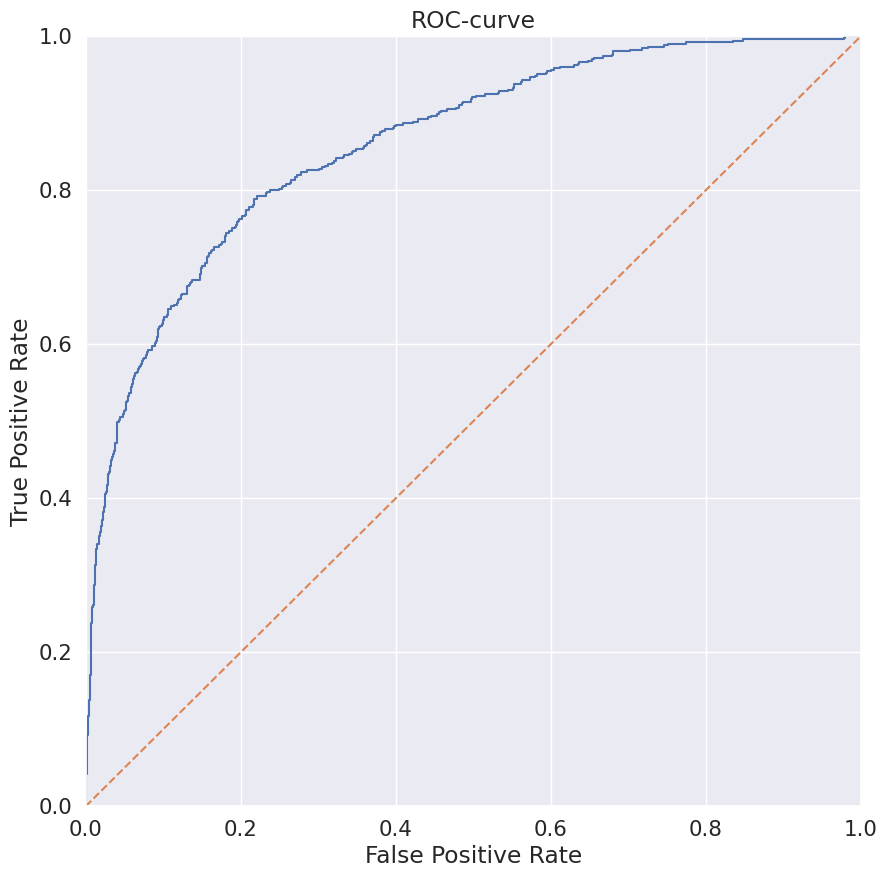

AUC_ROC 0.8608529695396873


In [168]:
probabilities_test = model_CatBoostClassifier_upsampled.predict_proba(X_test_upsampled)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_upsampled, probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(y_test_upsampled, probabilities_one_test)

print('AUC_ROC', auc_roc)

In [169]:
predictions = model_CatBoostClassifier_upsampled.predict(X_test_upsampled)

In [170]:
f1 = f1_score(y_test_upsampled, predictions)
print(f'F1 равна {f1}')

F1 равна 0.8059641345960105


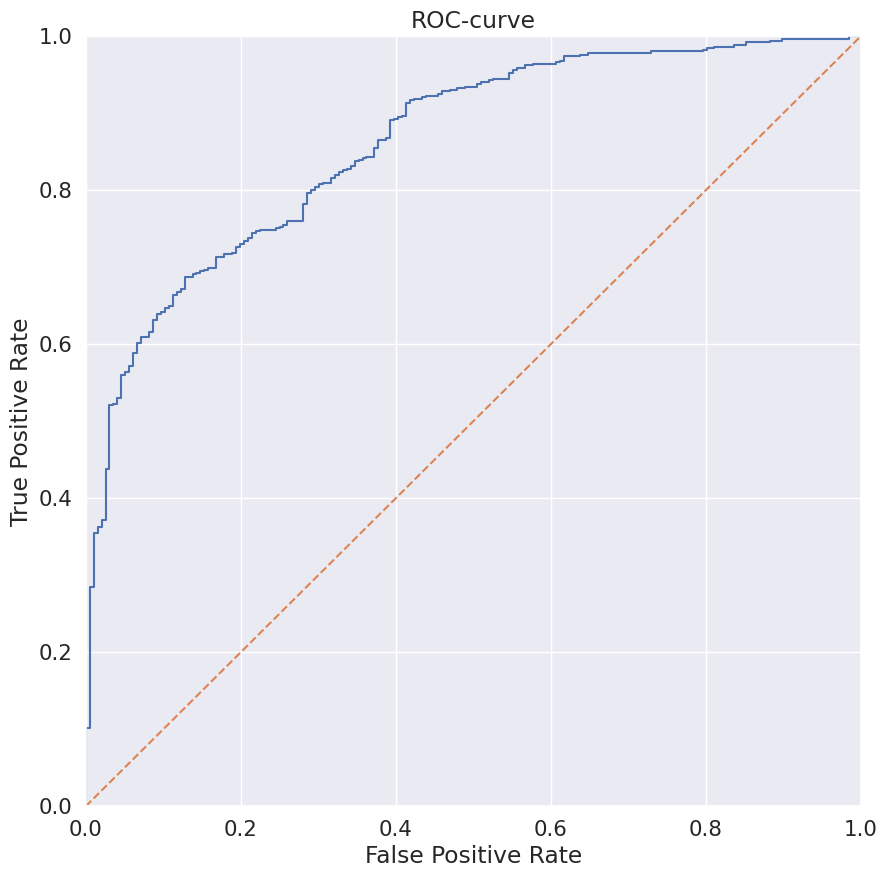

AUC_ROC: 0.8606688219842391


In [171]:
probabilities_test = model_CatBoostClassifier_downsampled.predict_proba(X_test_downsampled)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_downsampled, probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(y_test_downsampled, probabilities_one_test)

print('AUC_ROC:', auc_roc)

In [172]:
predictions = model_CatBoostClassifier_downsampled.predict(X_test_downsampled)

In [173]:
f1 = f1_score(y_test_downsampled, predictions)
print(f'F1 равна {f1}')

F1 равна 0.8813868613138687


**Для тестовой `upsampled` выборки `F1` равен `0.81`. `AUC_ROC` равен `0.87`.**  
**Для тестовой `downsampled` выборки `F1` равен `0.87`. `AUC_ROC` равен `0.86`.**

## Проверим модели на адекватность

In [174]:
strategies = ['most_frequent', 'prior', 'stratified', 'uniform']

for strategy in strategies:
    model = DummyClassifier(strategy=strategy, random_state=42)
    model.fit(X_train_encoded, y_train)
    result = model.score(X_test_encoded, y_test)
    display(f'{strategy} = {result}')

'most_frequent = 0.7952149229521492'

'prior = 0.7952149229521492'

'stratified = 0.6682887266828873'

'uniform = 0.5109489051094891'

**Результаты `обученных моделей` на `тестовой выборке` показали результат выше, чем результаты `DummyClassifier`. Это даёт право сделать вывод, что модели проходят проверку на адекватность.**

## Общий вывод

**Были исследованы три модели:**

* `DecisionTreeClassifier`
* `CatBoostClassifier`
* `LogisticRegression`

Наилучший результат показала модель `CatBoostClassifier`, `F1` метрика которой, на `тестовой downsampled выборке` показала результат - `0.87`.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*